#AML Detection Project
Welcome to my Project where I attempt to clean, sample, modify a computer generated transaction dataset, model and evaluate a machine and deep learning model using various models, in order to achieve great accuracy and metrics.

##Methodology used
The framework for the data project is using OSEMN Framework, which involves the following steps:

1. Obtain
2. Scrub
3. Explore
4. Model
5. Interpret



###Importing relevant libraries

In [ ]:
#Importing the relevant libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from google.colab import drive
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc, log_loss, cohen_kappa_score, matthews_corrcoef, roc_auc_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.layers import LSTM
import dask.dataframe as dd

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


#Obtain
For this section, the following steps are taken
1. Loading the dataset
2. Basic query on the dataset (No. of rows, datatypes, present of any null values, etc)

###Loading the Dataset(s)

In [ ]:
#Importing the dataset (High Illicit Levels + Small Transaction Volume)
##Dataset from: https://www.kaggle.com/datasets/ealtman2019/ibm-transactions-for-anti-money-laundering-aml
##Dataset generated using AMLSim, details of research paper is available here: https://arxiv.org/abs/2306.16424

large_df = pd.read_csv('/content/drive/MyDrive/FYP AML Dataset/HI-Large_Trans.csv')
medium_df = pd.read_csv('/content/drive/MyDrive/FYP AML Dataset/HI-Medium_Trans.csv')
small_df = pd.read_csv('/content/drive/MyDrive/FYP AML Dataset/HI-Small_Trans.csv')

In [ ]:
print(large_df.shape)
print(medium_df.shape)
print(small_df.shape)

(179702229, 11)
(31898238, 11)
(5078345, 11)


In [ ]:
print("Large: ", large_df['Is Laundering'].value_counts())
print("Medium: ", medium_df['Is Laundering'].value_counts())
print("Small: ", small_df['Is Laundering'].value_counts())

Large:  Is Laundering
0    179476683
1       225546
Name: count, dtype: int64
Medium:  Is Laundering
0    31863008
1       35230
Name: count, dtype: int64
Small:  Is Laundering
0    5073168
1       5177
Name: count, dtype: int64


##Sampling of the Dataset

In [ ]:
# Separate majority and minority classes
lar_majority = large_df[large_df['Is Laundering'] == 0]
lar_minority = large_df[large_df['Is Laundering'] == 1]

med_majority = medium_df[medium_df['Is Laundering'] == 0]
med_minority = medium_df[medium_df['Is Laundering'] == 1]

sm_majority = small_df[small_df['Is Laundering'] == 0]
sm_minority = small_df[small_df['Is Laundering'] == 1]

# Downsample majority class
n_factor_large = 1/150
n_factor_medium = 1/50
n_factor_small = 1/25

lar_majority_downsampled = lar_majority.sample(frac=n_factor_large, random_state=42)
med_majority_downsampled = med_majority.sample(frac=n_factor_medium, random_state=42)
sm_majority_downsampled = sm_majority.sample(frac=n_factor_small, random_state=42)

# Combine minority class with downsampled majority class
l_sample_df = pd.concat([lar_majority_downsampled, lar_minority])
m_sample_df = pd.concat([med_majority_downsampled, med_minority])
s_sample_df = pd.concat([sm_majority_downsampled, sm_minority])

# Display new class counts
print("Large: ", l_sample_df['Is Laundering'].value_counts())
print("Medium: ", m_sample_df['Is Laundering'].value_counts())
print("Small: ", s_sample_df['Is Laundering'].value_counts())

Large:  Is Laundering
0    1196511
1     225546
Name: count, dtype: int64
Medium:  Is Laundering
0    637260
1     35230
Name: count, dtype: int64
Small:  Is Laundering
0    202927
1      5177
Name: count, dtype: int64


### Basic Queries of the Dataset's Shape

In [ ]:
#Snippet
print("Snippet of the dataset: ", l_sample_df.head())

Snippet of the dataset:                    Timestamp  From Bank    Account  To Bank  Account.1  \
122378115  2022/10/05 14:32       4563  80EB6BCF0    43018  84E805BC0   
143307459  2022/10/17 19:53      28313  807C7DFA0    27076  817A33A60   
161829932  2022/10/28 02:41          1  8000804E0        3  8002028B0   
111972624  2022/09/30 00:05      51314  814F0FC30    51314  814F0FC30   
73463634   2022/09/08 19:21      24555  80216FAF0    11081  816DE7E60   

           Amount Received Receiving Currency  Amount Paid Payment Currency  \
122378115          3028.12          US Dollar      3028.12        US Dollar   
143307459          5588.61          US Dollar      5588.61        US Dollar   
161829932           290.76               Euro       290.76             Euro   
111972624          2259.66                Yen      2259.66              Yen   
73463634            242.18          US Dollar       242.18        US Dollar   

          Payment Format  Is Laundering  
122378115         C

In [ ]:
#Info
print("Info regarding the dataset: ", l_sample_df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 1422057 entries, 122378115 to 179701890
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   Timestamp           1422057 non-null  object 
 1   From Bank           1422057 non-null  int64  
 2   Account             1422057 non-null  object 
 3   To Bank             1422057 non-null  int64  
 4   Account.1           1422057 non-null  object 
 5   Amount Received     1422057 non-null  float64
 6   Receiving Currency  1422057 non-null  object 
 7   Amount Paid         1422057 non-null  float64
 8   Payment Currency    1422057 non-null  object 
 9   Payment Format      1422057 non-null  object 
 10  Is Laundering       1422057 non-null  int64  
dtypes: float64(2), int64(3), object(6)
memory usage: 130.2+ MB
Info regarding the dataset:  None


In [ ]:
#Description
print("Description of the dataset: ", l_sample_df.describe())

Description of the dataset:            From Bank       To Bank  Amount Received   Amount Paid  \
count  1.422057e+06  1.422057e+06     1.422057e+06  1.422057e+06   
mean   2.627947e+05  3.741643e+05     1.556934e+07  1.447141e+07   
std    5.661139e+05  6.240521e+05     4.733558e+09  4.717949e+09   
min    0.000000e+00  0.000000e+00     1.000000e-06  1.000000e-06   
25%    2.464000e+03  2.416800e+04     2.746800e+02  2.762500e+02   
50%    3.247000e+04  1.362390e+05     2.074040e+03  2.074130e+03   
75%    2.121740e+05  2.453980e+05     1.323523e+04  1.317628e+04   
max    3.225453e+06  3.225453e+06     5.257959e+12  5.257959e+12   

       Is Laundering  
count   1.422057e+06  
mean    1.586055e-01  
std     3.653079e-01  
min     0.000000e+00  
25%     0.000000e+00  
50%     0.000000e+00  
75%     0.000000e+00  
max     1.000000e+00  


In [ ]:
#Null Values
print("Null values in the dataset: ", l_sample_df.isnull().sum())

Null values in the dataset:  Timestamp             0
From Bank             0
Account               0
To Bank               0
Account.1             0
Amount Received       0
Receiving Currency    0
Amount Paid           0
Payment Currency      0
Payment Format        0
Is Laundering         0
dtype: int64


In [ ]:
#Shape of dataset
print("Shape of the dataset: ", l_sample_df.shape)

Shape of the dataset:  (1422057, 11)


In [ ]:
#Displaying the count of unique values in each column
def count_unique_values(df):
    unique_counts = {}

    for col in df.columns:
        unique_counts[col] = df[col].nunique()

    return pd.DataFrame.from_dict(unique_counts, orient='index', columns=['Unique Values'])

unique_counts_df = count_unique_values(l_sample_df)
print("Count of unique values in the dataset", unique_counts_df)

Count of unique values in the dataset                     Unique Values
Timestamp                  157115
From Bank                   29956
Account                    538555
To Bank                      9407
Account.1                  701802
Amount Received            727972
Receiving Currency             15
Amount Paid                730651
Payment Currency               15
Payment Format                  7
Is Laundering                   2


In [ ]:
#Displaying the Count of Money Laundering for HI-Medium dataset
ML_counts = l_sample_df['Is Laundering'].value_counts()
ML_count_table = pd.DataFrame({'Value': ML_counts.index, 'Count': ML_counts.values})
ML_count_table

Value    Count
0      0  1196511
1      1   225546

#Scrub
As part of the second step in the OSEMN Framework, this section is to perform cleaning towards the dataset, prior to exploring the dataset. However, as shown in the first section, there is no null-values and the data is consistent as this is a computer generated dataset, therefore no significant cleaning is needed.

However, some data transformation is required, to form better analyses for the dataset, which is breaking down of the timestamp column into individual columns for Year, Month, Day, Hour, Minute

###Breakdown of timestamp column

In [ ]:
l_clean = l_sample_df.copy()

# Convert 'Timestamp' to datetime objects
l_clean['Timestamp'] = pd.to_datetime(l_clean['Timestamp'])

# Extract year, month, day, hour, and second
l_clean['Year'] = l_clean['Timestamp'].dt.year.astype(int)
l_clean['Month'] = l_clean['Timestamp'].dt.month.astype(int)
l_clean['Day'] = l_clean['Timestamp'].dt.day.astype(int)
l_clean['Hour'] = l_clean['Timestamp'].dt.hour.astype(int)
l_clean['Second'] = l_clean['Timestamp'].dt.second.astype(int)

# Drop the 'Timestamp' and 'Second' as they are redundant for our analysis
l_clean = l_clean.drop('Timestamp', axis=1)
l_clean = l_clean.drop('Second', axis=1)

In [ ]:
m_clean = m_sample_df.copy()

# Convert 'Timestamp' to datetime objects
m_clean['Timestamp'] = pd.to_datetime(m_clean['Timestamp'])

# Extract year, month, day, hour, and second
m_clean['Year'] = m_clean['Timestamp'].dt.year.astype(int)
m_clean['Month'] = m_clean['Timestamp'].dt.month.astype(int)
m_clean['Day'] = m_clean['Timestamp'].dt.day.astype(int)
m_clean['Hour'] = m_clean['Timestamp'].dt.hour.astype(int)
m_clean['Second'] = m_clean['Timestamp'].dt.second.astype(int)

# Drop the 'Timestamp' and 'Second' as they are redundant for our analysis
m_clean = m_clean.drop('Timestamp', axis=1)
m_clean = m_clean.drop('Second', axis=1)

In [ ]:
s_clean = s_sample_df.copy()

# Convert 'Timestamp' to datetime objects
s_clean['Timestamp'] = pd.to_datetime(s_clean['Timestamp'])

# Extract year, month, day, hour, and second
s_clean['Year'] = s_clean['Timestamp'].dt.year.astype(int)
s_clean['Month'] = s_clean['Timestamp'].dt.month.astype(int)
s_clean['Day'] = s_clean['Timestamp'].dt.day.astype(int)
s_clean['Hour'] = s_clean['Timestamp'].dt.hour.astype(int)
s_clean['Second'] = s_clean['Timestamp'].dt.second.astype(int)

# Drop the 'Timestamp' and 'Second' as they are redundant for our analysis
s_clean = s_clean.drop('Timestamp', axis=1)
s_clean = s_clean.drop('Second', axis=1)

In [ ]:
# Checking output of the dataset
print(l_clean.head())
print(m_clean.head())
print(s_clean.head())

           From Bank    Account  To Bank  Account.1  Amount Received  \
122378115       4563  80EB6BCF0    43018  84E805BC0          3028.12   
143307459      28313  807C7DFA0    27076  817A33A60          5588.61   
161829932          1  8000804E0        3  8002028B0           290.76   
111972624      51314  814F0FC30    51314  814F0FC30          2259.66   
73463634       24555  80216FAF0    11081  816DE7E60           242.18   

          Receiving Currency  Amount Paid Payment Currency Payment Format  \
122378115          US Dollar      3028.12        US Dollar         Cheque   
143307459          US Dollar      5588.61        US Dollar           Cash   
161829932               Euro       290.76             Euro           Cash   
111972624                Yen      2259.66              Yen   Reinvestment   
73463634           US Dollar       242.18        US Dollar           Cash   

           Is Laundering  Year  Month  Day  Hour  
122378115              0  2022     10    5    14  
14

#Explore
This section of the project details out the process of Exploratory Data Analysis, EDA, of which includes the following analysis for both the dataset as well as the filtered, only money laundering transactions.
1. Distribution of Money Laundering Data within the dataset
2. Types of payment instruments used and its distribution
3. Total count of unique accounts (Paying and Receiving)
4. Types of Payment currency used and its distribution
5. Types of Receiving currency used and its distribution
6. Total amount of Money Laundered as a proportion to Total transacted amount
7. Distribution of the Money Laundering by time (Year, Month, Day, Hour)

Creating a separate dataset that is purely ML transactions

In [ ]:
l_sample_df_ML = l_clean[l_clean['Is Laundering'] == 1]

###Distribution of ML Transactions

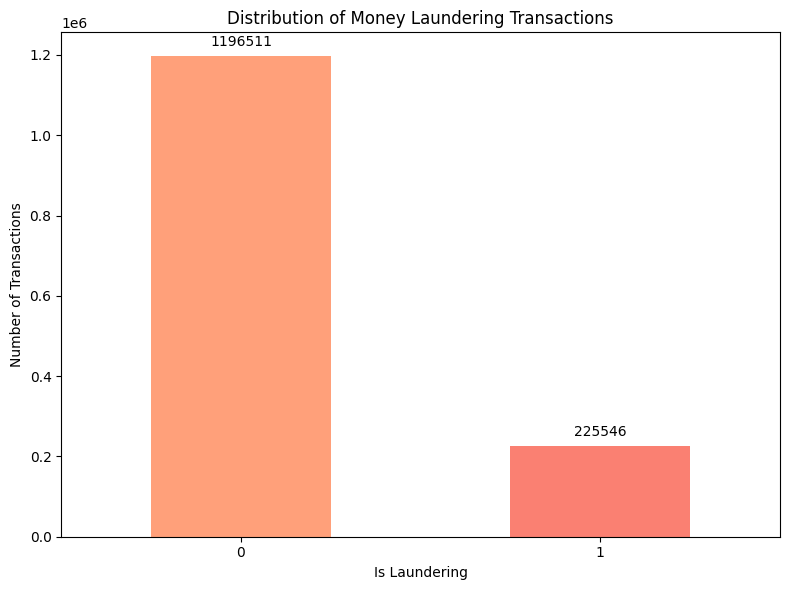

In [ ]:
# Create the bar chart
plt.figure(figsize=(8, 6))  # Adjust figure size if needed
ax = l_clean['Is Laundering'].value_counts().plot(kind='bar', color=['#FFA07A', '#FA8072', '#E9967A'])  # Warm colors

# Add data labels
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')

# Customize the chart
plt.title('Distribution of Money Laundering Transactions')
plt.xlabel('Is Laundering')
plt.ylabel('Number of Transactions')
plt.xticks(rotation=0)  # Rotate x-axis labels if needed
plt.tight_layout()  # Adjust layout to prevent labels from overlapping
plt.show()

###Distribution of types of Payment Currency and Receiving Currencies used

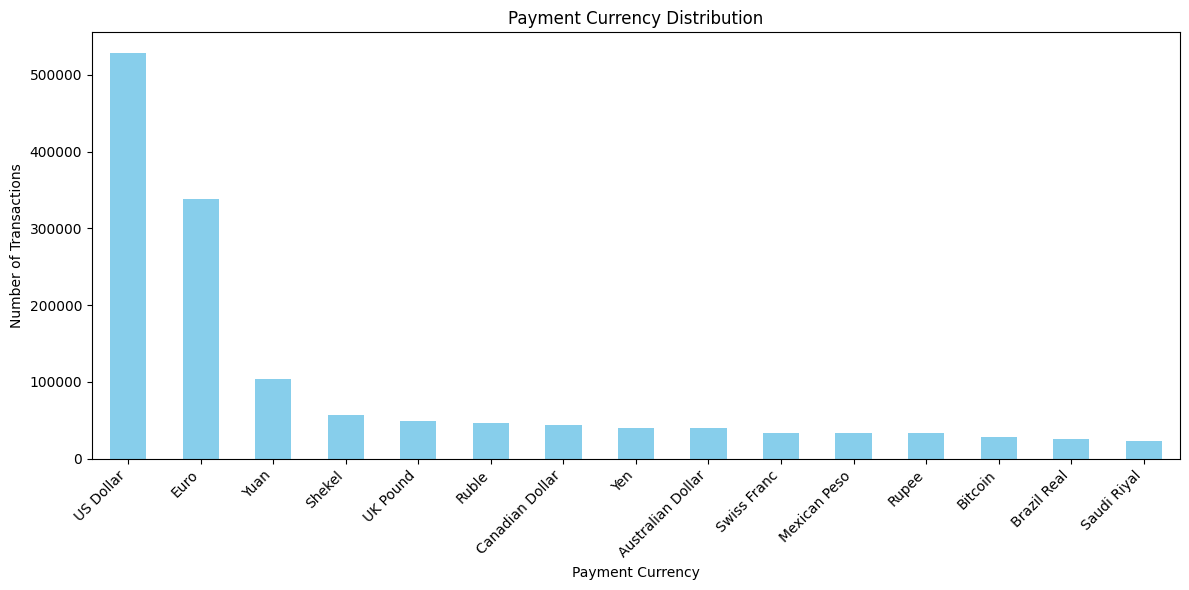

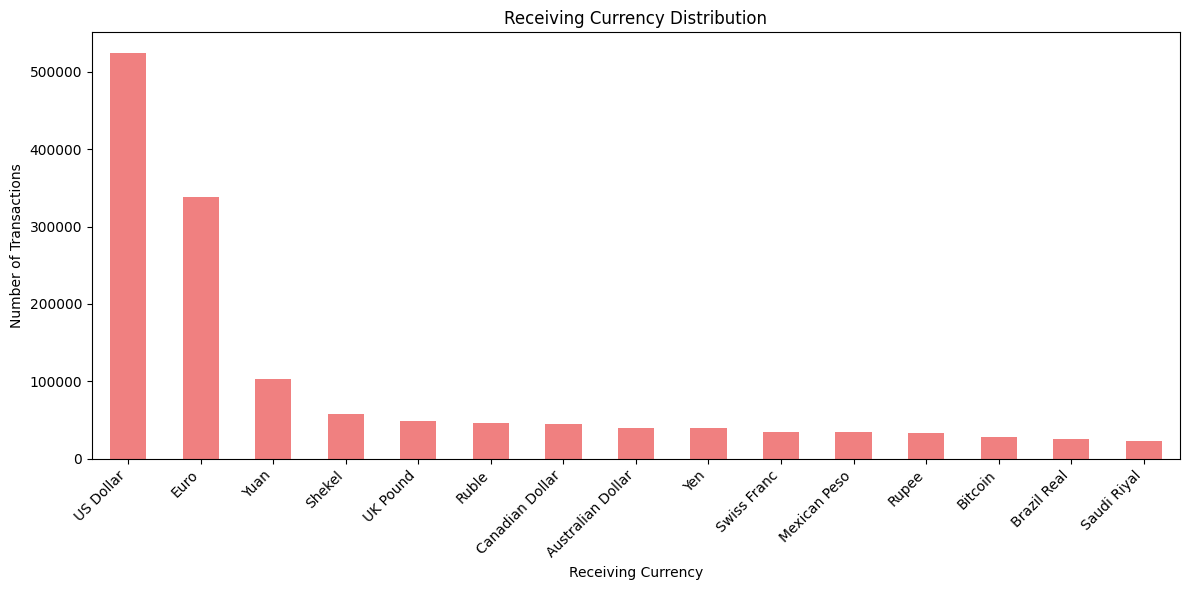

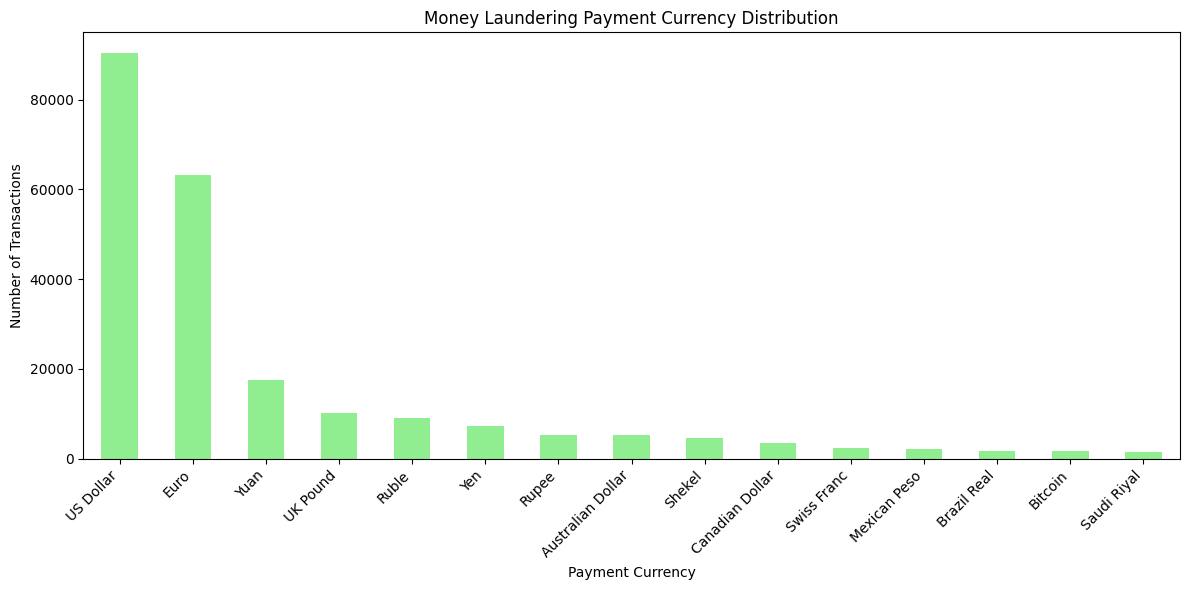

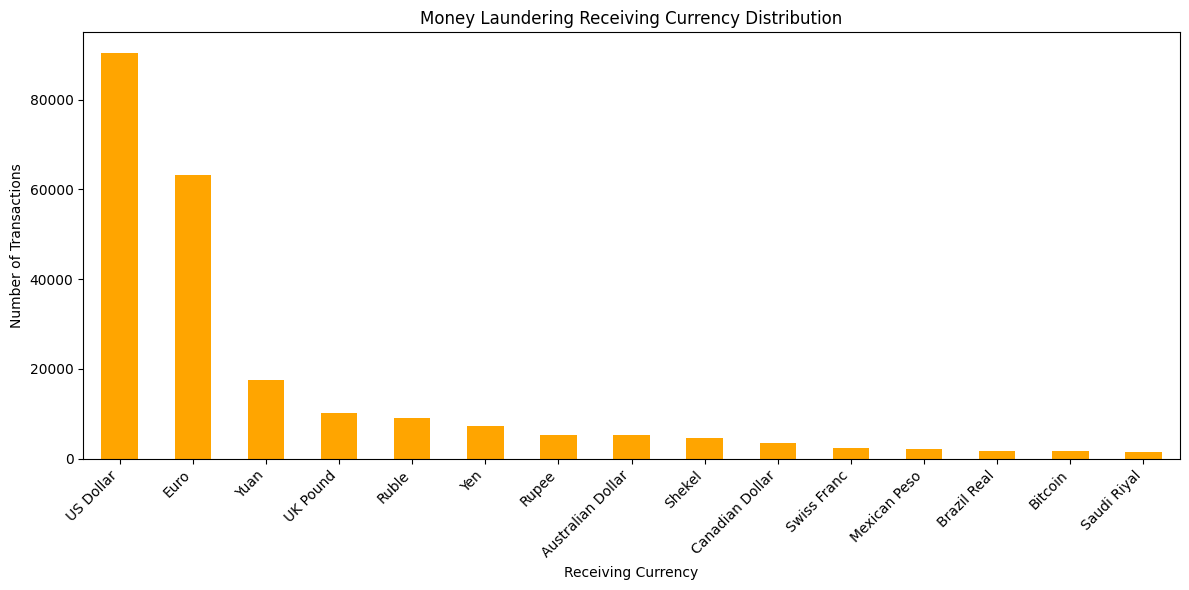

In [ ]:
# Payment Currency Distribution
plt.figure(figsize=(12, 6))
payment_currency_counts = l_clean['Payment Currency'].value_counts().sort_values(ascending=False)
payment_currency_counts.plot(kind='bar', color='skyblue')
plt.title('Payment Currency Distribution')
plt.xlabel('Payment Currency')
plt.ylabel('Number of Transactions')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Receiving Currency Distribution
plt.figure(figsize=(12, 6))
receiving_currency_counts = l_clean['Receiving Currency'].value_counts().sort_values(ascending=False)
receiving_currency_counts.plot(kind='bar', color='lightcoral')
plt.title('Receiving Currency Distribution')
plt.xlabel('Receiving Currency')
plt.ylabel('Number of Transactions')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


# Payment Currency Distribution (ML Transactions)
plt.figure(figsize=(12, 6))
l_sample_df_ML_payment_currency_counts = l_sample_df_ML['Payment Currency'].value_counts().sort_values(ascending=False)
l_sample_df_ML_payment_currency_counts.plot(kind='bar', color='lightgreen')
plt.title('Money Laundering Payment Currency Distribution')
plt.xlabel('Payment Currency')
plt.ylabel('Number of Transactions')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


# Receiving Currency Distribution (ML Transactions)
plt.figure(figsize=(12, 6))
l_sample_df_ML_receiving_currency_counts = l_sample_df_ML['Receiving Currency'].value_counts().sort_values(ascending=False)
l_sample_df_ML_receiving_currency_counts.plot(kind='bar', color='orange')
plt.title('Money Laundering Receiving Currency Distribution')
plt.xlabel('Receiving Currency')
plt.ylabel('Number of Transactions')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

###Histogram for Transactions (ML and Non-ML)

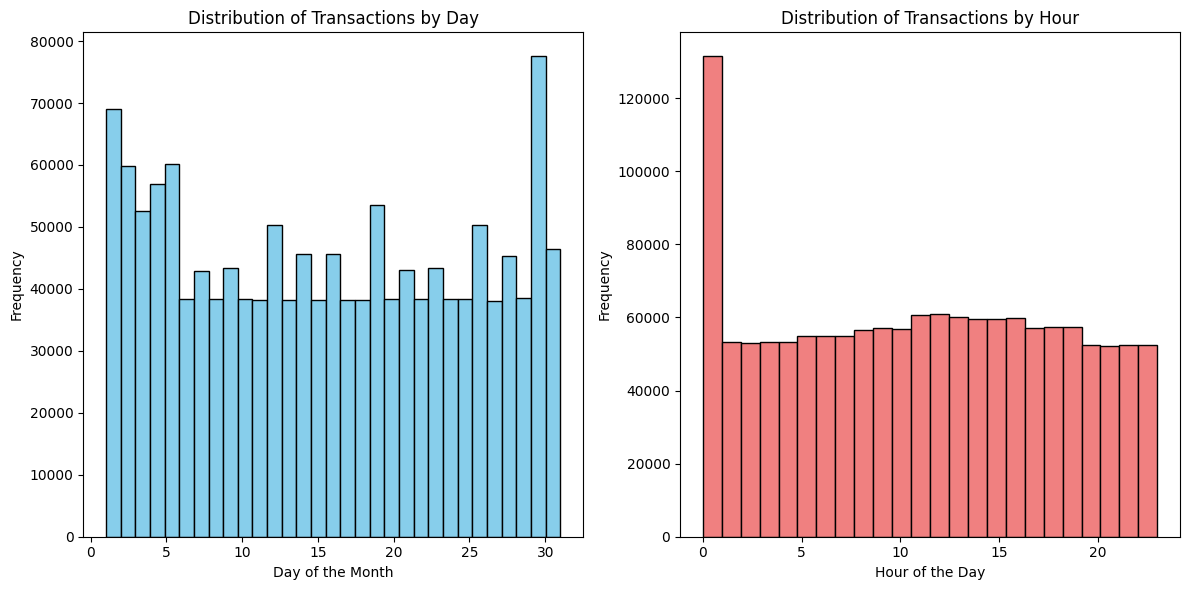

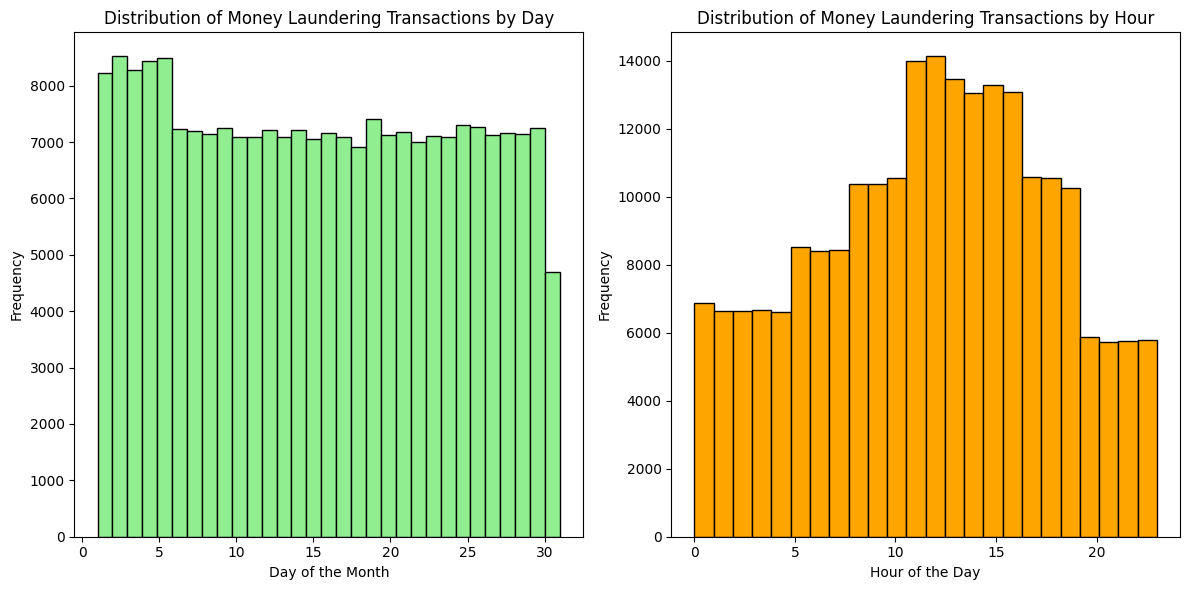

In [ ]:
# Histogram for all transactions (Day and Hour)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(l_clean['Day'], bins=31, color='skyblue', edgecolor='black')  # Assuming days 1-31
plt.title('Distribution of Transactions by Day')
plt.xlabel('Day of the Month')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(l_clean['Hour'], bins=24, color='lightcoral', edgecolor='black')  # 24 hours
plt.title('Distribution of Transactions by Hour')
plt.xlabel('Hour of the Day')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Histogram for ML Transactions (Day and Hour)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(l_sample_df_ML['Day'], bins=31, color='lightgreen', edgecolor='black')  # Assuming days 1-31
plt.title('Distribution of Money Laundering Transactions by Day')
plt.xlabel('Day of the Month')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(l_sample_df_ML['Hour'], bins=24, color='orange', edgecolor='black')  # 24 hours
plt.title('Distribution of Money Laundering Transactions by Hour')
plt.xlabel('Hour of the Day')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

###Payment Format types distribution

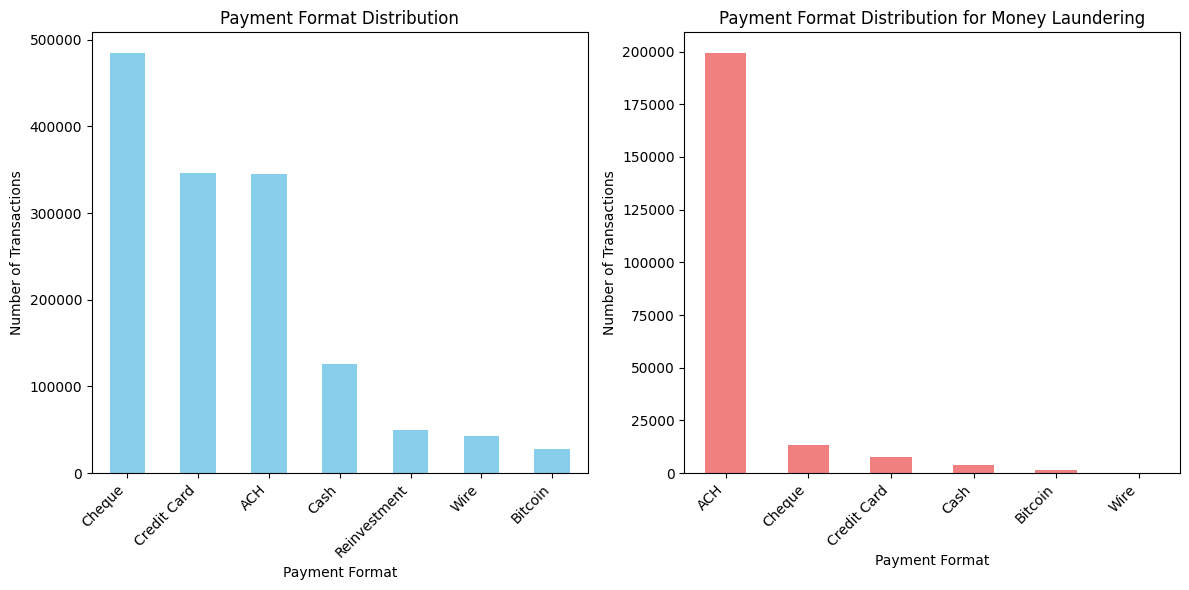

In [ ]:
plt.figure(figsize=(12, 6))

# Payment Format for all transactions
plt.subplot(1, 2, 1)
l_clean['Payment Format'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Payment Format Distribution')
plt.xlabel('Payment Format')
plt.ylabel('Number of Transactions')
plt.xticks(rotation=45, ha='right')

# Payment Format for ML transactions
plt.subplot(1, 2, 2)
l_sample_df_ML['Payment Format'].value_counts().plot(kind='bar', color='lightcoral')
plt.title('Payment Format Distribution for Money Laundering')
plt.xlabel('Payment Format')
plt.ylabel('Number of Transactions')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

#Model
This section of the project performs dataset modification in order to prepare for machine learning modelling.

###Data Pre-Processing: Encoding
- Label Encoding - For Columns Account & Account.1
- One-Hot Encoding - Payment & Receiving Currency, Payment Format

###Data Pre-Processing: Over-Sampling
- SMOTE (Baseline) - To Address the minority class of Money Laundering = 1 (True)

###Hyperparameter Tuning
- GridSearchCV - To find the best parameters to be used for the Machine Learning and Deep Learning Models

###Machine Learning Models
- Random Forest
- Naive Bayes Classification
- Logistic Regression
- Decision Tree

###MDeep Learning Models
- Keras Deep Learning Model
- Convolutional Neural Networks (CNNs)
- Long Short-Term Memory (LSTM) Networks
- AutoEncoders
- Graph Convolutional Networks (GCNs)

##Pre-Modelling Steps

####Re-Import packages and Libraries

In [ ]:
#Importing the relevant libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from google.colab import drive
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc, log_loss, cohen_kappa_score, matthews_corrcoef, roc_auc_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.layers import LSTM
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
from sklearn.ensemble import AdaBoostClassifier
import seaborn as sns

###Data Pre-Processing Step

In [ ]:
mldata_l = l_clean.copy()
mldata_m = m_clean.copy()
mldata_s = s_clean.copy()

###Label Encoding

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the 'Account' column
mldata_l['Account'] = label_encoder.fit_transform(mldata_l['Account'])

# Fit and transform the 'Account.1' column
mldata_l['Account.1'] = label_encoder.fit_transform(mldata_l['Account.1'])


In [ ]:
# Fit and transform the 'Account' column
mldata_m['Account'] = label_encoder.fit_transform(mldata_m['Account'])

# Fit and transform the 'Account.1' column
mldata_m['Account.1'] = label_encoder.fit_transform(mldata_m['Account.1'])

In [ ]:
# Fit and transform the 'Account' column
mldata_s['Account'] = label_encoder.fit_transform(mldata_s['Account'])

# Fit and transform the 'Account.1' column
mldata_s['Account.1'] = label_encoder.fit_transform(mldata_s['Account.1'])

###One-Hot Encoding

In [ ]:
# Perform one-hot encoding for specified columns
mldata_l = pd.get_dummies(mldata_l, columns=['Payment Currency', 'Receiving Currency', 'Payment Format'], prefix=['Payment_Currency', 'Receiving_Currency', 'Payment_Format'])

In [ ]:
# Perform one-hot encoding for specified columns
mldata_m = pd.get_dummies(mldata_m, columns=['Payment Currency', 'Receiving Currency', 'Payment Format'], prefix=['Payment_Currency', 'Receiving_Currency', 'Payment_Format'])

In [ ]:
# Perform one-hot encoding for specified columns
mldata_s = pd.get_dummies(mldata_s, columns=['Payment Currency', 'Receiving Currency', 'Payment Format'], prefix=['Payment_Currency', 'Receiving_Currency', 'Payment_Format'])

Correlation heatmap

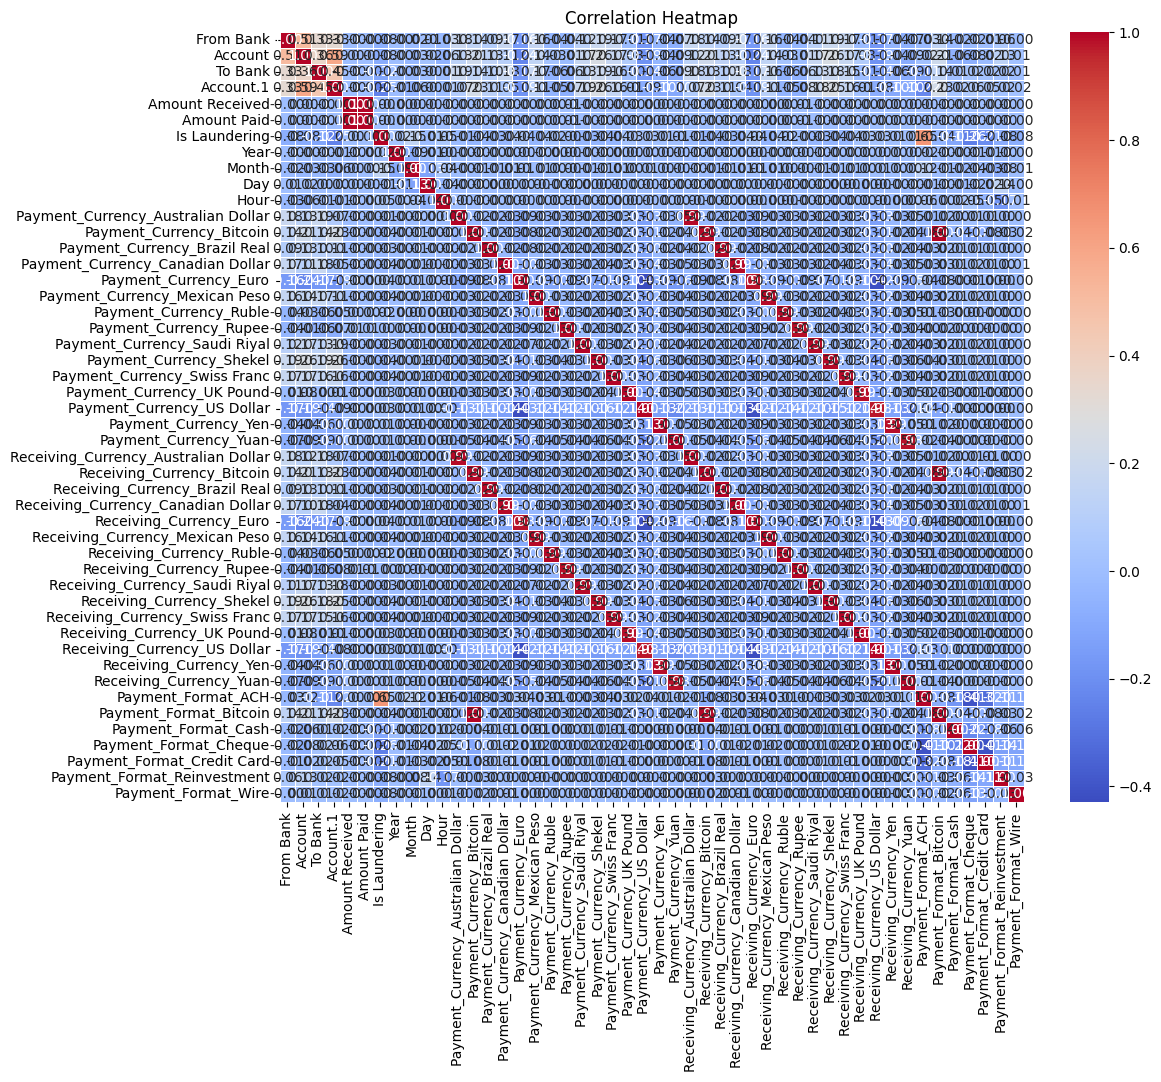

In [ ]:
plt.figure(figsize=(12, 10))  # Increased figure size for better visualization
correlation_matrix = mldata_l.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5) # Added linewidths
plt.title('Correlation Heatmap')
plt.show()

###Train Test Split
Train = mldata_l
Test = mldata_m
Validation = mldata_s


In [ ]:
train = mldata_l
test = mldata_m
validation = mldata_s

In [ ]:
X_train = train.drop('Is Laundering', axis=1)
y_train = train['Is Laundering']
X_test = test.drop('Is Laundering', axis=1)
y_test = test['Is Laundering']
X_val = validation.drop('Is Laundering', axis=1)
y_val = validation['Is Laundering']

##Machine Learning Models

####Defining the models used

In [ ]:
decision_tree = DecisionTreeClassifier(random_state=42)
naive_bayes = GaussianNB()
logistic_regression = LogisticRegression(n_jobs=-1, random_state=42)
random_forest = RandomForestClassifier(n_jobs=-1, random_state=42)
gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)
xgb_model = xgb.XGBClassifier(n_estimators=100, random_state=42)
ada_model = AdaBoostClassifier(n_estimators=100, random_state=42)

###Baseline Machine Learning Models

####Baseline Naive Bayes Model

Naive Bayes - Accuracy: 0.9474936430281491
Naive Bayes - Precision: 0.24358974358974358
Naive Bayes - Recall: 0.0010786261708770934
Naive Bayes - F1 Score: 0.0021477420448765046
Naive Bayes - False Positive Rate: 0.00018516774942723535


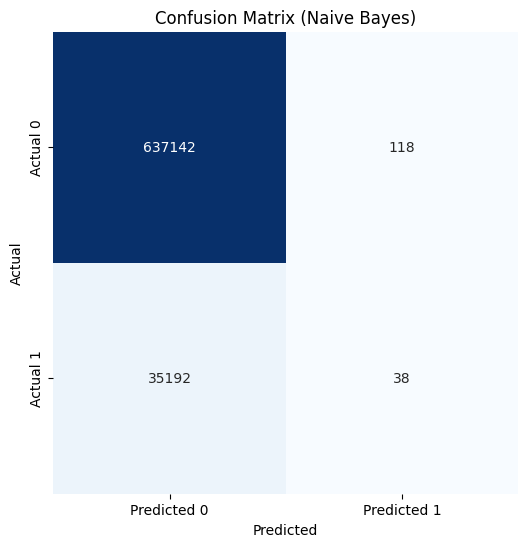

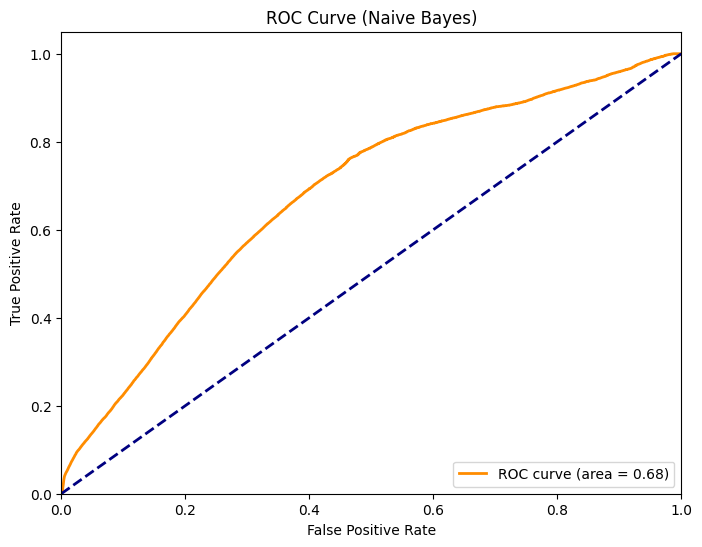

In [ ]:
# Train Naive Bayes model
naive_bayes.fit(X_train, y_train)
y_pred_nb = naive_bayes.predict(X_test)
y_prob_nb = naive_bayes.predict_proba(X_test)[:, 1]

# Evaluate the model
accuracy_nb = accuracy_score(y_test, y_pred_nb)
precision_nb = precision_score(y_test, y_pred_nb)
recall_nb = recall_score(y_test, y_pred_nb)
f1_nb = f1_score(y_test, y_pred_nb)

# Calculate the confusion matrix
conf_matrix_nb = confusion_matrix(y_test, y_pred_nb)

# Extract TN, FP, FN, TP from the confusion matrix
TN = conf_matrix_nb[0, 0]
FP = conf_matrix_nb[0, 1]
FN = conf_matrix_nb[1, 0]
TP = conf_matrix_nb[1, 1]

# Calculate False Positive Rate (FPR)
FPR_nb = FP / (FP+TN)

# ROC Curve
fpr_nb, tpr_nb, thresholds_nb = roc_curve(y_test, y_prob_nb)
roc_auc_nb = auc(fpr_nb, tpr_nb)

print(f"Naive Bayes - Accuracy: {accuracy_nb}")
print(f"Naive Bayes - Precision: {precision_nb}")
print(f"Naive Bayes - Recall: {recall_nb}")
print(f"Naive Bayes - F1 Score: {f1_nb}")
print(f"Naive Bayes - False Positive Rate: {FPR_nb}")

# Visualize the Confusion Matrix
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix_nb, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix (Naive Bayes)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Visualize the ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_nb, tpr_nb, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_nb:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Naive Bayes)')
plt.legend(loc="lower right")
plt.show()

Naive Bayes Validation - Accuracy: 0.9749067773805405
Naive Bayes Validation - Precision: 0.09090909090909091
Naive Bayes Validation - Recall: 0.0009658103148541626
Naive Bayes Validation - F1 Score: 0.00191131498470948
Naive Bayes Validation - False Positive Rate: 0.0002463940234665668


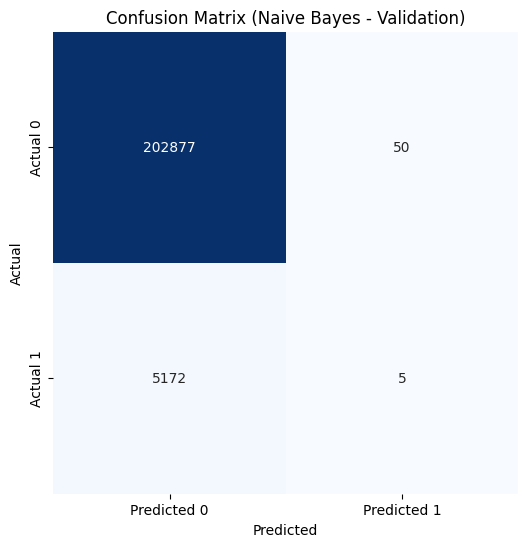

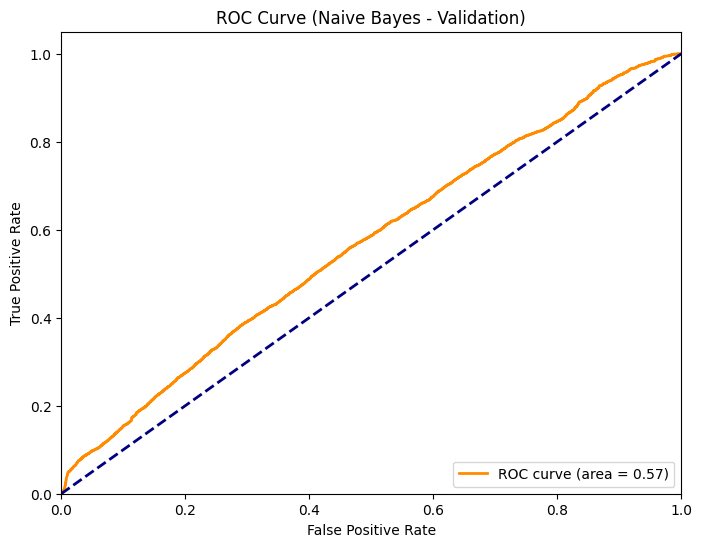

In [ ]:
# prompt: validate the naive bayes model with X_val and y_val

# Validate the Naive Bayes model with X_val and y_val
y_pred_nb_val = naive_bayes.predict(X_val)
y_prob_nb_val = naive_bayes.predict_proba(X_val)[:, 1]

# Evaluate the model on the validation set
accuracy_nb_val = accuracy_score(y_val, y_pred_nb_val)
precision_nb_val = precision_score(y_val, y_pred_nb_val)
recall_nb_val = recall_score(y_val, y_pred_nb_val)
f1_nb_val = f1_score(y_val, y_pred_nb_val)

# Calculate the confusion matrix for the validation set
conf_matrix_nb_val = confusion_matrix(y_val, y_pred_nb_val)

# Extract TN, FP, FN, TP from the confusion matrix
TN_val = conf_matrix_nb_val[0, 0]
FP_val = conf_matrix_nb_val[0, 1]
FN_val = conf_matrix_nb_val[1, 0]
TP_val = conf_matrix_nb_val[1, 1]

# Calculate False Positive Rate (FPR) for the validation set
FPR_nb_val = FP_val / (FP_val + TN_val)

# ROC Curve for the validation set
fpr_nb_val, tpr_nb_val, thresholds_nb_val = roc_curve(y_val, y_prob_nb_val)
roc_auc_nb_val = auc(fpr_nb_val, tpr_nb_val)


print(f"Naive Bayes Validation - Accuracy: {accuracy_nb_val}")
print(f"Naive Bayes Validation - Precision: {precision_nb_val}")
print(f"Naive Bayes Validation - Recall: {recall_nb_val}")
print(f"Naive Bayes Validation - F1 Score: {f1_nb_val}")
print(f"Naive Bayes Validation - False Positive Rate: {FPR_nb_val}")

# Visualize the Confusion Matrix for the validation set
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix_nb_val, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix (Naive Bayes - Validation)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Visualize the ROC Curve for the validation set
plt.figure(figsize=(8, 6))
plt.plot(fpr_nb_val, tpr_nb_val, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_nb_val:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Naive Bayes - Validation)')
plt.legend(loc="lower right")
plt.show()

####Baseline Random Forest Model

Random Forest - Accuracy: 0.9607785989382742
Random Forest - Precision: 0.60099926993977
Random Forest - Recall: 0.7477434005109281
Random Forest - F1 Score: 0.6663884040373378
Random Forest - False Positive Rate: 0.027444057370617957


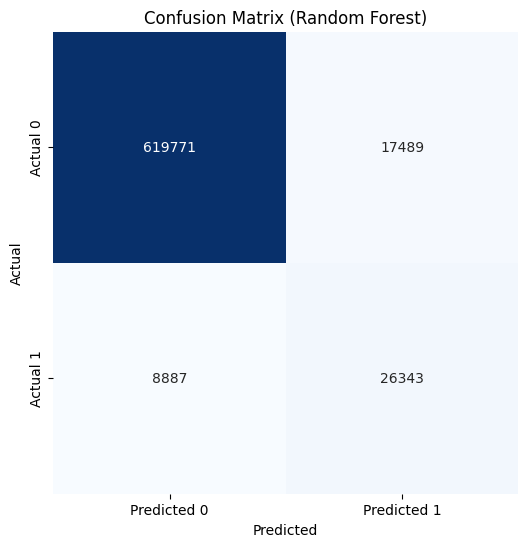

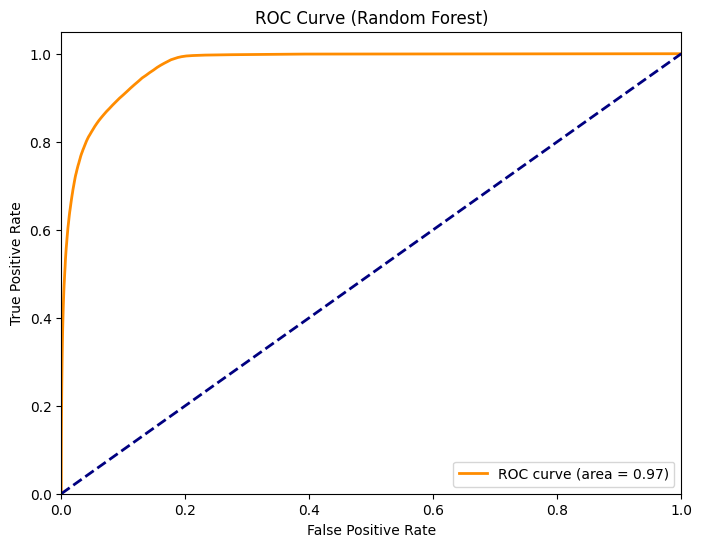

In [ ]:
# Train Random Forest model
random_forest.fit(X_train, y_train)
y_pred_rf = random_forest.predict(X_test)
y_prob_rf = random_forest.predict_proba(X_test)[:, 1]

# Evaluate the model
accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)

# Calculate the confusion matrix
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)

# Extract TN, FP, FN, TP from the confusion matrix
TN = conf_matrix_rf[0, 0]
FP = conf_matrix_rf[0, 1]
FN = conf_matrix_rf[1, 0]
TP = conf_matrix_rf[1, 1]

# Calculate False Positive Rate (FPR)
FPR_rf = FP / (FP + TN)

# ROC Curve
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_prob_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

print(f"Random Forest - Accuracy: {accuracy_rf}")
print(f"Random Forest - Precision: {precision_rf}")
print(f"Random Forest - Recall: {recall_rf}")
print(f"Random Forest - F1 Score: {f1_rf}")
print(f"Random Forest - False Positive Rate: {FPR_rf}")

# Visualize the Confusion Matrix
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix (Random Forest)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Visualize the ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_rf:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Random Forest)')
plt.legend(loc="lower right")
plt.show()

Random Forest Validation - Accuracy: 0.9575692922769384
Random Forest Validation - Precision: 0.33244656453536375
Random Forest Validation - Recall: 0.7000193162062971
Random Forest Validation - F1 Score: 0.4508023385993283
Random Forest Validation - False Positive Rate: 0.03586018617532413


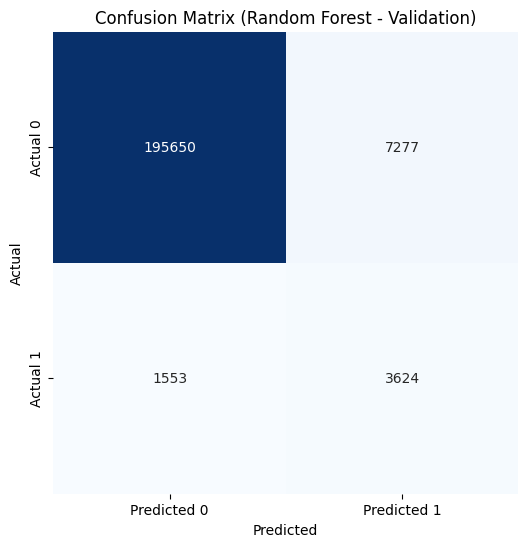

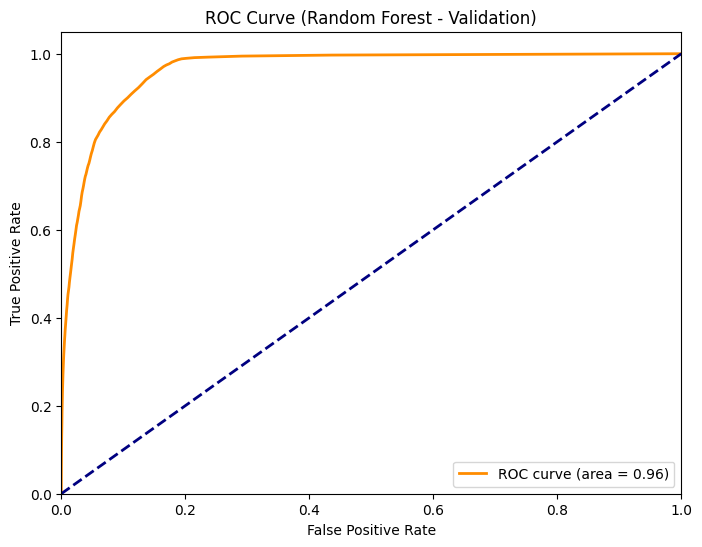

In [ ]:
# Validate the Random Forest model with X_val and y_val
y_pred_rf_val = random_forest.predict(X_val)
y_prob_rf_val = random_forest.predict_proba(X_val)[:, 1]

# Evaluate the model on the validation set
accuracy_rf_val = accuracy_score(y_val, y_pred_rf_val)
precision_rf_val = precision_score(y_val, y_pred_rf_val)
recall_rf_val = recall_score(y_val, y_pred_rf_val)
f1_rf_val = f1_score(y_val, y_pred_rf_val)

# Calculate the confusion matrix for the validation set
conf_matrix_rf_val = confusion_matrix(y_val, y_pred_rf_val)

# Extract TN, FP, FN, TP from the confusion matrix
TN_val = conf_matrix_rf_val[0, 0]
FP_val = conf_matrix_rf_val[0, 1]
FN_val = conf_matrix_rf_val[1, 0]
TP_val = conf_matrix_rf_val[1, 1]

# Calculate False Positive Rate (FPR) for the validation set
FPR_rf_val = FP_val / (FP_val + TN_val)

# ROC Curve for the validation set
fpr_rf_val, tpr_rf_val, thresholds_rf_val = roc_curve(y_val, y_prob_rf_val)
roc_auc_rf_val = auc(fpr_rf_val, tpr_rf_val)

print(f"Random Forest Validation - Accuracy: {accuracy_rf_val}")
print(f"Random Forest Validation - Precision: {precision_rf_val}")
print(f"Random Forest Validation - Recall: {recall_rf_val}")
print(f"Random Forest Validation - F1 Score: {f1_rf_val}")
print(f"Random Forest Validation - False Positive Rate: {FPR_rf_val}")

# Visualize the Confusion Matrix for the validation set
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix_rf_val, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix (Random Forest - Validation)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Visualize the ROC Curve for the validation set
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf_val, tpr_rf_val, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_rf_val:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Random Forest - Validation)')
plt.legend(loc="lower right")
plt.show()

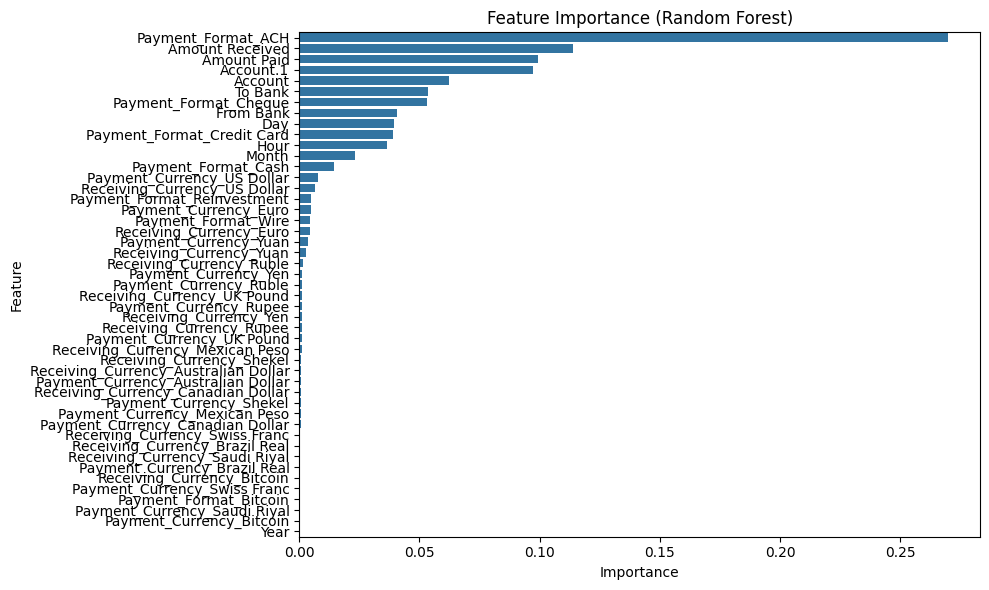

In [ ]:
feature_importances = random_forest.feature_importances_

feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance (Random Forest)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

####Baseline Logistic Regression Model

Logistic Regression - Accuracy: 0.949090692798406
Logistic Regression - Precision: 0.5894206549118388
Logistic Regression - Recall: 0.0929889298892989
Logistic Regression - F1 Score: 0.16063548102383055
Logistic Regression - False Positive Rate: 0.0035809559677368735


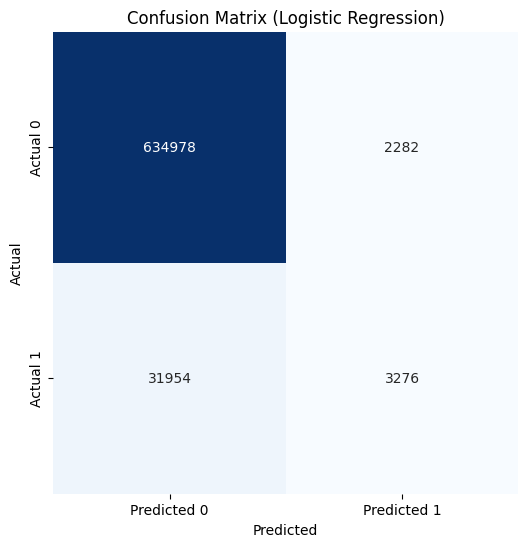

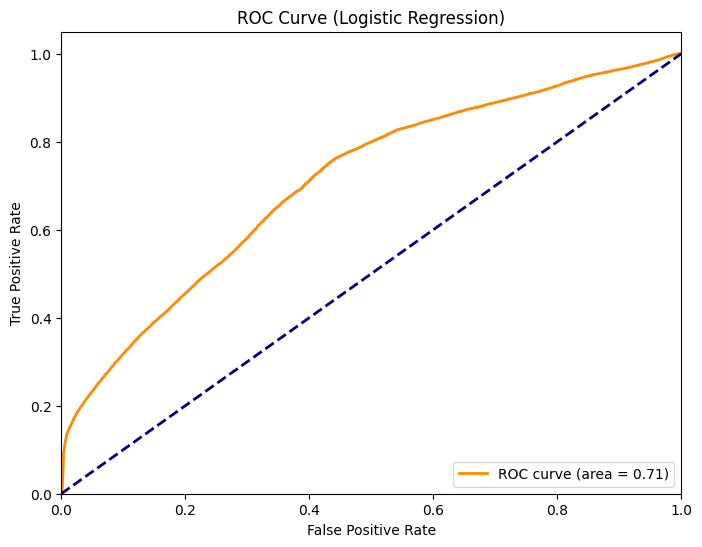

In [ ]:
# Train Logistic Regression model
logistic_regression.fit(X_train, y_train)
y_pred_lr = logistic_regression.predict(X_test)
y_prob_lr = logistic_regression.predict_proba(X_test)[:, 1]

# Evaluate the model
accuracy_lr = accuracy_score(y_test, y_pred_lr)
precision_lr = precision_score(y_test, y_pred_lr)
recall_lr = recall_score(y_test, y_pred_lr)
f1_lr = f1_score(y_test, y_pred_lr)

# Calculate the confusion matrix
conf_matrix_lr = confusion_matrix(y_test, y_pred_lr)

# Extract TN, FP, FN, TP from the confusion matrix
TN = conf_matrix_lr[0, 0]
FP = conf_matrix_lr[0, 1]
FN = conf_matrix_lr[1, 0]
TP = conf_matrix_lr[1, 1]

# Calculate False Positive Rate (FPR)
FPR_lr = FP / (FP + TN)

# ROC Curve
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_test, y_prob_lr)
roc_auc_lr = auc(fpr_lr, tpr_lr)

print(f"Logistic Regression - Accuracy: {accuracy_lr}")
print(f"Logistic Regression - Precision: {precision_lr}")
print(f"Logistic Regression - Recall: {recall_lr}")
print(f"Logistic Regression - F1 Score: {f1_lr}")
print(f"Logistic Regression - False Positive Rate: {FPR_lr}")

# Visualize the Confusion Matrix
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix_lr, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix (Logistic Regression)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Visualize the ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_lr, tpr_lr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_lr:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Logistic Regression)')
plt.legend(loc="lower right")
plt.show()

Logistic Regression Validation - Accuracy: 0.9730999884673048
Logistic Regression Validation - Precision: 0.3244370308590492
Logistic Regression Validation - Recall: 0.07514004249565386
Logistic Regression Validation - F1 Score: 0.12202007528230865
Logistic Regression Validation - False Positive Rate: 0.003991583180158382


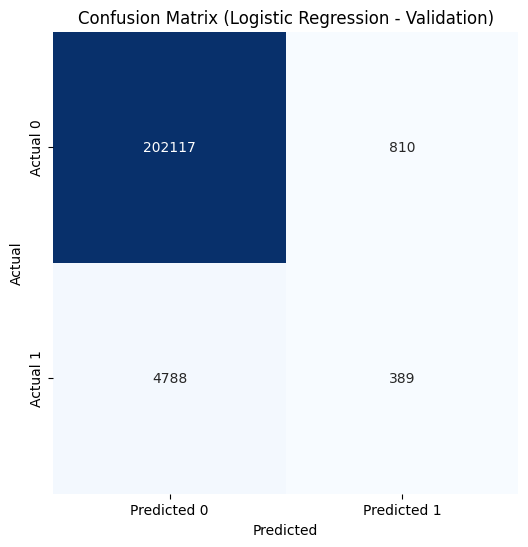

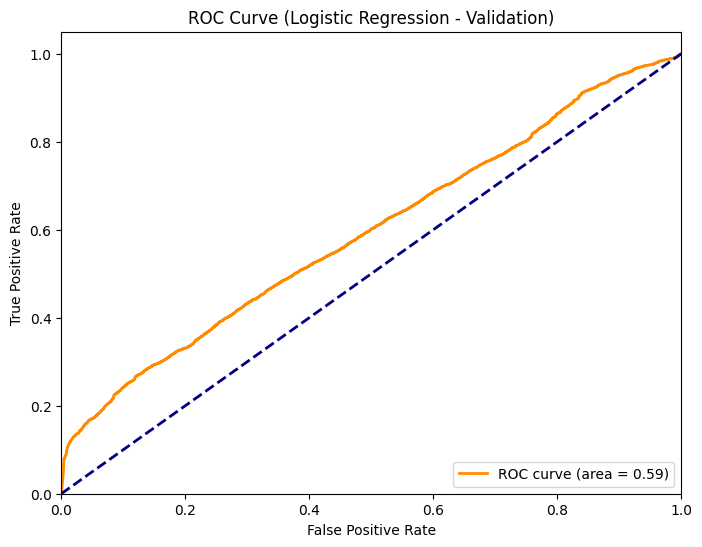

In [ ]:
# prompt: validate the logistic regression model with X_val and y_val

# Validate the Logistic Regression model with X_val and y_val
y_pred_lr_val = logistic_regression.predict(X_val)
y_prob_lr_val = logistic_regression.predict_proba(X_val)[:, 1]

# Evaluate the model on the validation set
accuracy_lr_val = accuracy_score(y_val, y_pred_lr_val)
precision_lr_val = precision_score(y_val, y_pred_lr_val)
recall_lr_val = recall_score(y_val, y_pred_lr_val)
f1_lr_val = f1_score(y_val, y_pred_lr_val)

# Calculate the confusion matrix for the validation set
conf_matrix_lr_val = confusion_matrix(y_val, y_pred_lr_val)

# Extract TN, FP, FN, TP from the confusion matrix
TN_val = conf_matrix_lr_val[0, 0]
FP_val = conf_matrix_lr_val[0, 1]
FN_val = conf_matrix_lr_val[1, 0]
TP_val = conf_matrix_lr_val[1, 1]

# Calculate False Positive Rate (FPR) for the validation set
FPR_lr_val = FP_val / (FP_val + TN_val)

# ROC Curve for the validation set
fpr_lr_val, tpr_lr_val, thresholds_lr_val = roc_curve(y_val, y_prob_lr_val)
roc_auc_lr_val = auc(fpr_lr_val, tpr_lr_val)

print(f"Logistic Regression Validation - Accuracy: {accuracy_lr_val}")
print(f"Logistic Regression Validation - Precision: {precision_lr_val}")
print(f"Logistic Regression Validation - Recall: {recall_lr_val}")
print(f"Logistic Regression Validation - F1 Score: {f1_lr_val}")
print(f"Logistic Regression Validation - False Positive Rate: {FPR_lr_val}")

# Visualize the Confusion Matrix for the validation set
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix_lr_val, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix (Logistic Regression - Validation)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Visualize the ROC Curve for the validation set
plt.figure(figsize=(8, 6))
plt.plot(fpr_lr_val, tpr_lr_val, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_lr_val:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Logistic Regression - Validation)')
plt.legend(loc="lower right")
plt.show()

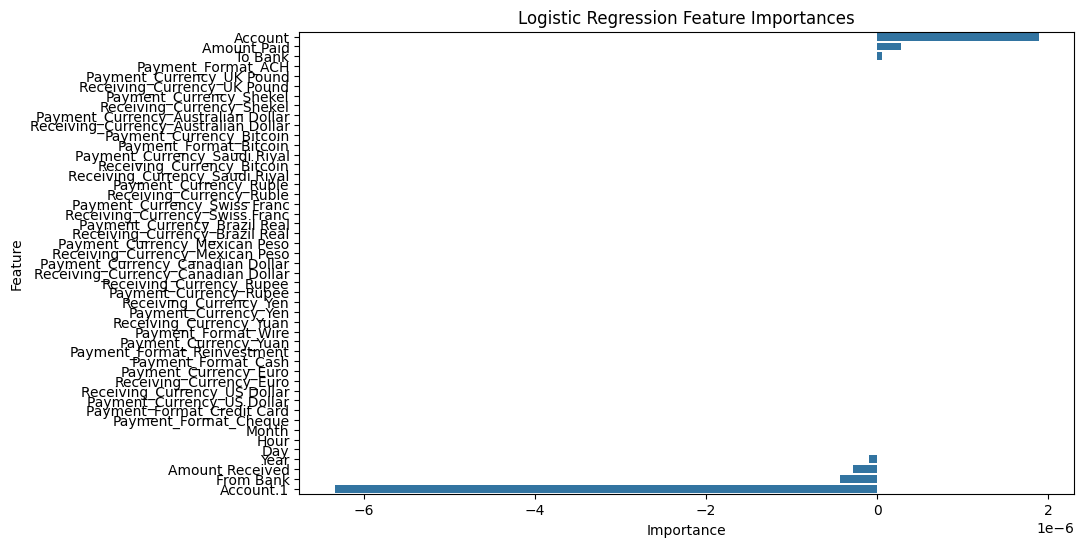

In [ ]:
feature_importances = logistic_regression.coef_[0]

feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Logistic Regression Feature Importances')
plt.show()

####Baseline Decision Tree Model

Decision Tree - Accuracy: 0.9298785112046276
Decision Tree - Precision: 0.4032765612327656
Decision Tree - Recall: 0.7057053647459551
Decision Tree - F1 Score: 0.513253509496284
Decision Tree - False Positive Rate: 0.057728399711263846


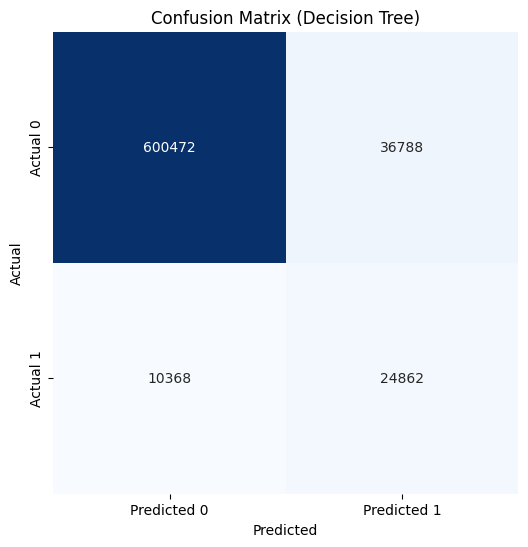

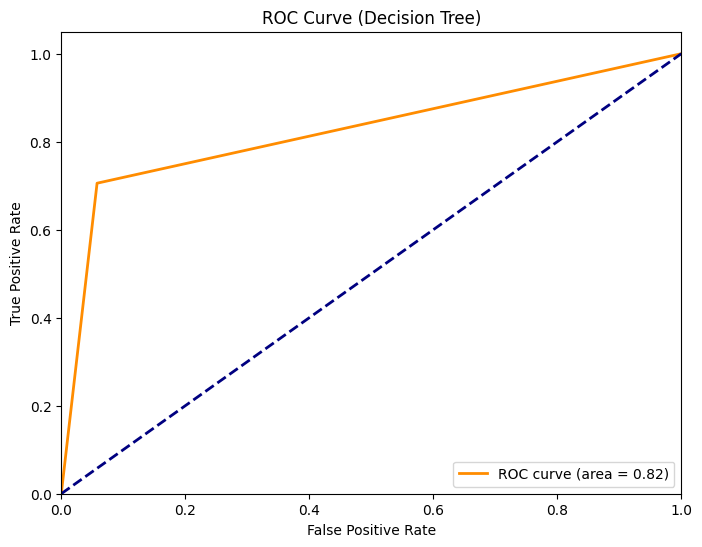

In [ ]:
# Train Decision Tree model
decision_tree.fit(X_train, y_train)
y_pred_dt = decision_tree.predict(X_test)
y_prob_dt = decision_tree.predict_proba(X_test)[:, 1]

# Evaluate the model
accuracy_dt = accuracy_score(y_test, y_pred_dt)
precision_dt = precision_score(y_test, y_pred_dt)
recall_dt = recall_score(y_test, y_pred_dt)
f1_dt = f1_score(y_test, y_pred_dt)

# Calculate the confusion matrix
conf_matrix_dt = confusion_matrix(y_test, y_pred_dt)

# Extract TN, FP, FN, TP from the confusion matrix
TN = conf_matrix_dt[0, 0]
FP = conf_matrix_dt[0, 1]
FN = conf_matrix_dt[1, 0]
TP = conf_matrix_dt[1, 1]

# Calculate False Positive Rate (FPR)
FPR_dt = FP / (FP + TN)

# ROC Curve
fpr_dt, tpr_dt, thresholds_dt = roc_curve(y_test, y_prob_dt)
roc_auc_dt = auc(fpr_dt, tpr_dt)

print(f"Decision Tree - Accuracy: {accuracy_dt}")
print(f"Decision Tree - Precision: {precision_dt}")
print(f"Decision Tree - Recall: {recall_dt}")
print(f"Decision Tree - F1 Score: {f1_dt}")
print(f"Decision Tree - False Positive Rate: {FPR_dt}")

# Visualize the Confusion Matrix
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix_dt, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix (Decision Tree)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Visualize the ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_dt, tpr_dt, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_dt:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Decision Tree)')
plt.legend(loc="lower right")
plt.show()

Decision Tree Validation - Accuracy: 0.9279302656364126
Decision Tree Validation - Precision: 0.20938628158844766
Decision Tree Validation - Recall: 0.6834073787908055
Decision Tree Validation - F1 Score: 0.320558122678264
Decision Tree Validation - False Positive Rate: 0.06583155518979732


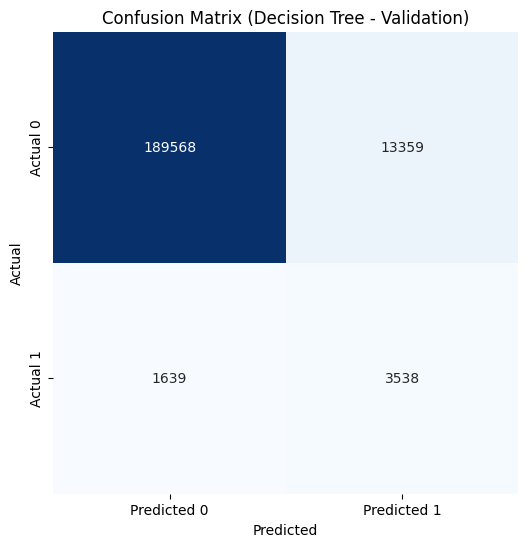

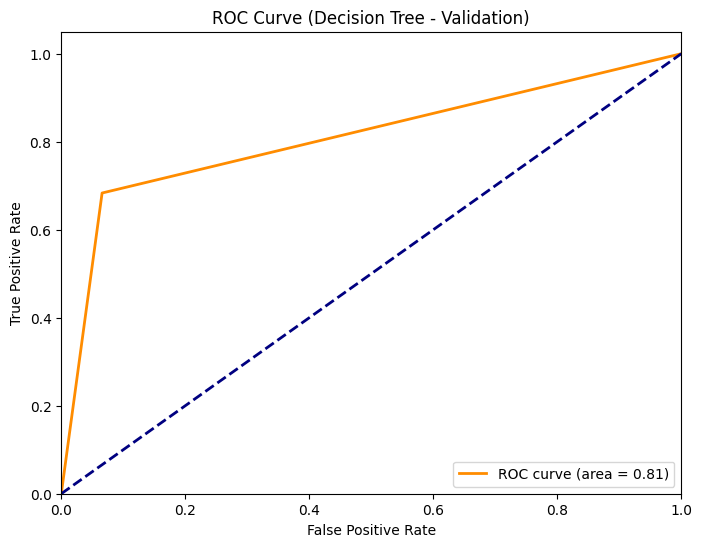

In [ ]:
# Validate the Decision Tree model with X_val and y_val
y_pred_dt_val = decision_tree.predict(X_val)
y_prob_dt_val = decision_tree.predict_proba(X_val)[:, 1]

# Evaluate the model on the validation set
accuracy_dt_val = accuracy_score(y_val, y_pred_dt_val)
precision_dt_val = precision_score(y_val, y_pred_dt_val)
recall_dt_val = recall_score(y_val, y_pred_dt_val)
f1_dt_val = f1_score(y_val, y_pred_dt_val)

# Calculate the confusion matrix for the validation set
conf_matrix_dt_val = confusion_matrix(y_val, y_pred_dt_val)

# Extract TN, FP, FN, TP from the confusion matrix
TN_val = conf_matrix_dt_val[0, 0]
FP_val = conf_matrix_dt_val[0, 1]
FN_val = conf_matrix_dt_val[1, 0]
TP_val = conf_matrix_dt_val[1, 1]

# Calculate False Positive Rate (FPR) for the validation set
FPR_dt_val = FP_val / (FP_val + TN_val)

# ROC Curve for the validation set
fpr_dt_val, tpr_dt_val, thresholds_dt_val = roc_curve(y_val, y_prob_dt_val)
roc_auc_dt_val = auc(fpr_dt_val, tpr_dt_val)

print(f"Decision Tree Validation - Accuracy: {accuracy_dt_val}")
print(f"Decision Tree Validation - Precision: {precision_dt_val}")
print(f"Decision Tree Validation - Recall: {recall_dt_val}")
print(f"Decision Tree Validation - F1 Score: {f1_dt_val}")
print(f"Decision Tree Validation - False Positive Rate: {FPR_dt_val}")

# Visualize the Confusion Matrix for the validation set
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix_dt_val, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix (Decision Tree - Validation)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Visualize the ROC Curve for the validation set
plt.figure(figsize=(8, 6))
plt.plot(fpr_dt_val, tpr_dt_val, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_dt_val:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Decision Tree - Validation)')
plt.legend(loc="lower right")
plt.show()

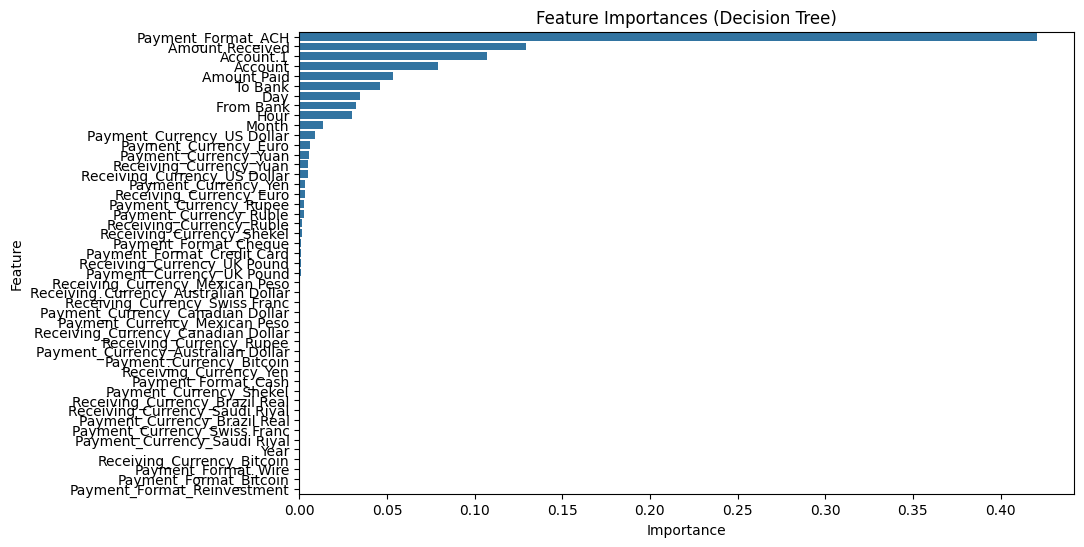

In [ ]:
feature_importances = decision_tree.feature_importances_

feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importances (Decision Tree)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

####Baseline Gradient Boost Model

Gradient Boosting - Accuracy: 0.9418385403500423
Gradient Boosting - Precision: 0.4667841439838497
Gradient Boosting - Recall: 0.7744535906897531
Gradient Boosting - F1 Score: 0.5824873773764158
Gradient Boosting - False Positive Rate: 0.04890782412202241


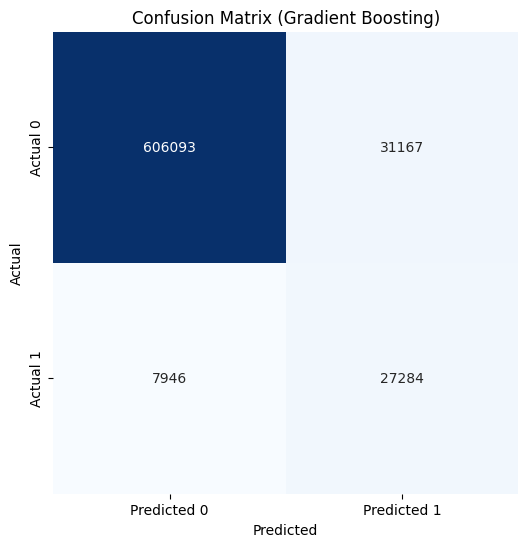

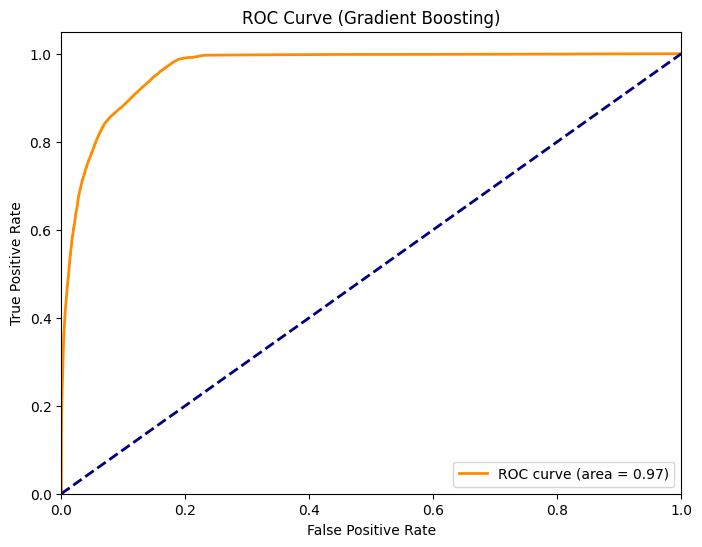

In [ ]:
gb_model.fit(X_train, y_train)
y_pred_gb = gb_model.predict(X_test)
y_prob_gb = gb_model.predict_proba(X_test)[:, 1]

# Evaluate the model
accuracy_gb = accuracy_score(y_test, y_pred_gb)
precision_gb = precision_score(y_test, y_pred_gb)
recall_gb = recall_score(y_test, y_pred_gb)
f1_gb = f1_score(y_test, y_pred_gb)

# Calculate the confusion matrix
conf_matrix_gb = confusion_matrix(y_test, y_pred_gb)

# Extract TN, FP, FN, TP from the confusion matrix
TN = conf_matrix_gb[0, 0]
FP = conf_matrix_gb[0, 1]
FN = conf_matrix_gb[1, 0]
TP = conf_matrix_gb[1, 1]

# Calculate False Positive Rate (FPR)
FPR_gb = FP / (FP + TN)

# ROC Curve
fpr_gb, tpr_gb, thresholds_gb = roc_curve(y_test, y_prob_gb)
roc_auc_gb = auc(fpr_gb, tpr_gb)

print(f"Gradient Boosting - Accuracy: {accuracy_gb}")
print(f"Gradient Boosting - Precision: {precision_gb}")
print(f"Gradient Boosting - Recall: {recall_gb}")
print(f"Gradient Boosting - F1 Score: {f1_gb}")
print(f"Gradient Boosting - False Positive Rate: {FPR_gb}")


# Visualize the Confusion Matrix
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix_gb, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix (Gradient Boosting)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Visualize the ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_gb, tpr_gb, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_gb:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Gradient Boosting)')
plt.legend(loc="lower right")
plt.show()

Gradient Boosting Validation - Accuracy: 0.9330238726790451
Gradient Boosting Validation - Precision: 0.24426411349173915
Gradient Boosting Validation - Recall: 0.8081900714699632
Gradient Boosting Validation - F1 Score: 0.3751457007083296
Gradient Boosting Validation - False Positive Rate: 0.06379141267549414


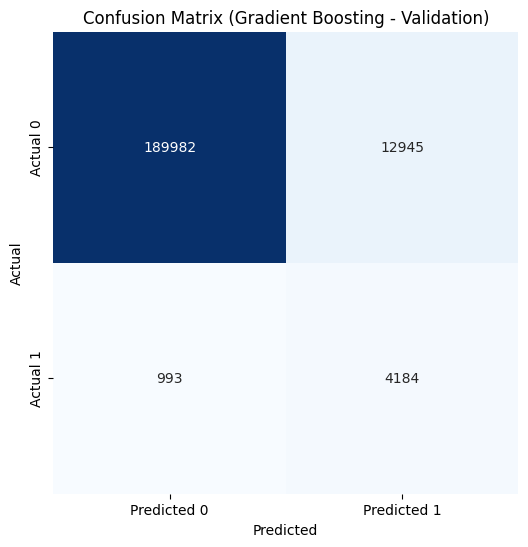

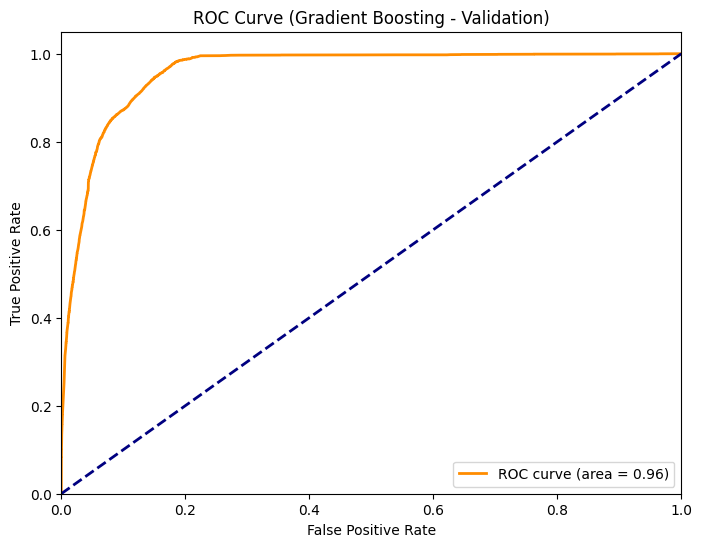

In [ ]:
# Validate the Gradient Boosting model with X_val and y_val
y_pred_gb_val = gb_model.predict(X_val)
y_prob_gb_val = gb_model.predict_proba(X_val)[:, 1]

# Evaluate the model on the validation set
accuracy_gb_val = accuracy_score(y_val, y_pred_gb_val)
precision_gb_val = precision_score(y_val, y_pred_gb_val)
recall_gb_val = recall_score(y_val, y_pred_gb_val)
f1_gb_val = f1_score(y_val, y_pred_gb_val)

# Calculate the confusion matrix for the validation set
conf_matrix_gb_val = confusion_matrix(y_val, y_pred_gb_val)

# Extract TN, FP, FN, TP from the confusion matrix
TN_val = conf_matrix_gb_val[0, 0]
FP_val = conf_matrix_gb_val[0, 1]
FN_val = conf_matrix_gb_val[1, 0]
TP_val = conf_matrix_gb_val[1, 1]

# Calculate False Positive Rate (FPR) for the validation set
FPR_gb_val = FP_val / (FP_val + TN_val)

# ROC Curve for the validation set
fpr_gb_val, tpr_gb_val, thresholds_gb_val = roc_curve(y_val, y_prob_gb_val)
roc_auc_gb_val = auc(fpr_gb_val, tpr_gb_val)

print(f"Gradient Boosting Validation - Accuracy: {accuracy_gb_val}")
print(f"Gradient Boosting Validation - Precision: {precision_gb_val}")
print(f"Gradient Boosting Validation - Recall: {recall_gb_val}")
print(f"Gradient Boosting Validation - F1 Score: {f1_gb_val}")
print(f"Gradient Boosting Validation - False Positive Rate: {FPR_gb_val}")

# Visualize the Confusion Matrix for the validation set
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix_gb_val, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix (Gradient Boosting - Validation)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Visualize the ROC Curve for the validation set
plt.figure(figsize=(8, 6))
plt.plot(fpr_gb_val, tpr_gb_val, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_gb_val:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Gradient Boosting - Validation)')
plt.legend(loc="lower right")
plt.show()

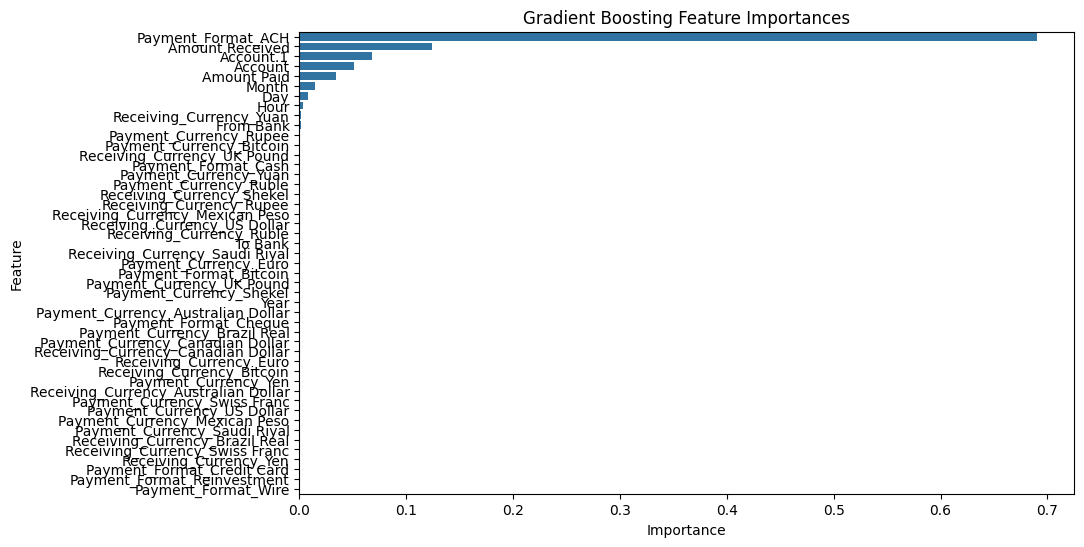

In [ ]:
importances_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': gb_model.feature_importances_})
importances_df = importances_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importances_df)
plt.title('Gradient Boosting Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

####Baseline XGBoost Model

XGBoost - Accuracy: 0.9576603369566834
XGBoost - Precision: 0.571936548493559
XGBoost - Recall: 0.762446778313937
XGBoost - F1 Score: 0.6535920676440172
XGBoost - False Positive Rate: 0.03154756300411135


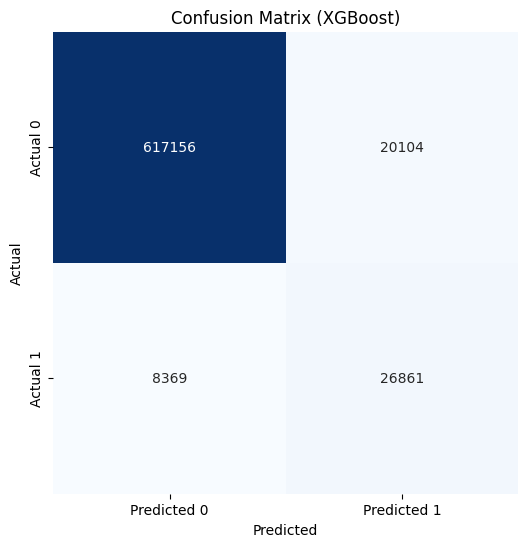

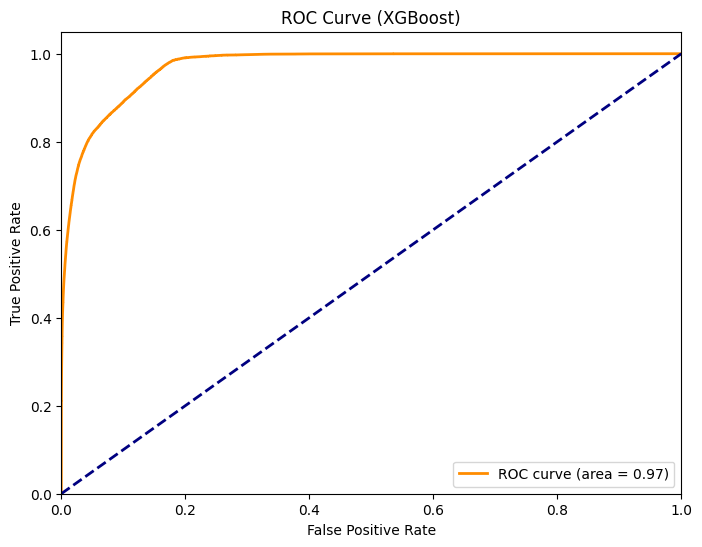

In [ ]:
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
y_prob_xgb = xgb_model.predict_proba(X_test)[:, 1]

# Evaluate the model
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
precision_xgb = precision_score(y_test, y_pred_xgb)
recall_xgb = recall_score(y_test, y_pred_xgb)
f1_xgb = f1_score(y_test, y_pred_xgb)

# Calculate the confusion matrix
conf_matrix_xgb = confusion_matrix(y_test, y_pred_xgb)

# Extract TN, FP, FN, TP from the confusion matrix
TN = conf_matrix_xgb[0, 0]
FP = conf_matrix_xgb[0, 1]
FN = conf_matrix_xgb[1, 0]
TP = conf_matrix_xgb[1, 1]

# Calculate False Positive Rate (FPR)
FPR_xgb = FP / (FP + TN)

# ROC Curve
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(y_test, y_prob_xgb)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

print(f"XGBoost - Accuracy: {accuracy_xgb}")
print(f"XGBoost - Precision: {precision_xgb}")
print(f"XGBoost - Recall: {recall_xgb}")
print(f"XGBoost - F1 Score: {f1_xgb}")
print(f"XGBoost - False Positive Rate: {FPR_xgb}")


# Visualize the Confusion Matrix
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix_xgb, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix (XGBoost)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Visualize the ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_xgb, tpr_xgb, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_xgb:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (XGBoost)')
plt.legend(loc="lower right")
plt.show()

XGBoost Validation - Accuracy: 0.9522258101718372
XGBoost Validation - Precision: 0.31583829326737267
XGBoost Validation - Recall: 0.7892601892988217
XGBoost Validation - F1 Score: 0.4511427625041404
XGBoost Validation - False Positive Rate: 0.043616670034051654


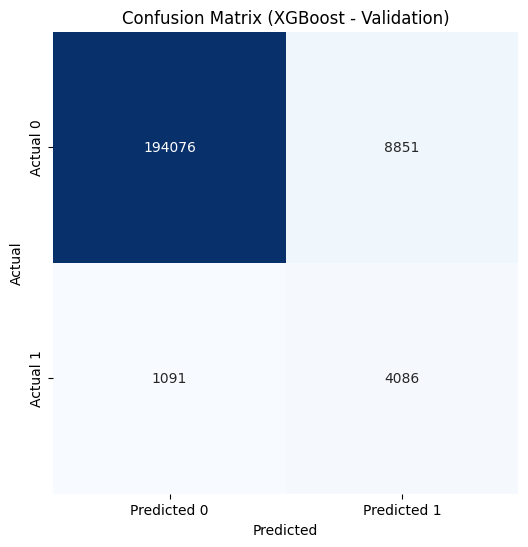

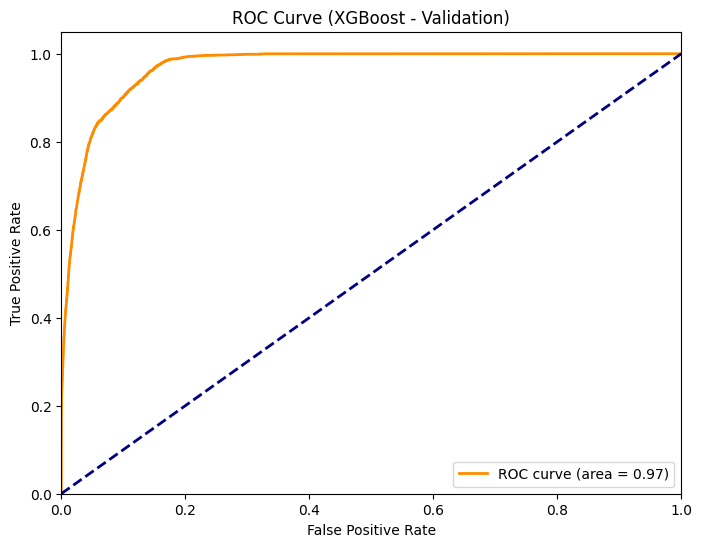

In [ ]:
# Validate the XGBoost model with X_val and y_val
y_pred_xgb_val = xgb_model.predict(X_val)
y_prob_xgb_val = xgb_model.predict_proba(X_val)[:, 1]

# Evaluate the model on the validation set
accuracy_xgb_val = accuracy_score(y_val, y_pred_xgb_val)
precision_xgb_val = precision_score(y_val, y_pred_xgb_val)
recall_xgb_val = recall_score(y_val, y_pred_xgb_val)
f1_xgb_val = f1_score(y_val, y_pred_xgb_val)

# Calculate the confusion matrix for the validation set
conf_matrix_xgb_val = confusion_matrix(y_val, y_pred_xgb_val)

# Extract TN, FP, FN, TP from the confusion matrix
TN_val = conf_matrix_xgb_val[0, 0]
FP_val = conf_matrix_xgb_val[0, 1]
FN_val = conf_matrix_xgb_val[1, 0]
TP_val = conf_matrix_xgb_val[1, 1]

# Calculate False Positive Rate (FPR) for the validation set
FPR_xgb_val = FP_val / (FP_val + TN_val)

# ROC Curve for the validation set
fpr_xgb_val, tpr_xgb_val, thresholds_xgb_val = roc_curve(y_val, y_prob_xgb_val)
roc_auc_xgb_val = auc(fpr_xgb_val, tpr_xgb_val)

print(f"XGBoost Validation - Accuracy: {accuracy_xgb_val}")
print(f"XGBoost Validation - Precision: {precision_xgb_val}")
print(f"XGBoost Validation - Recall: {recall_xgb_val}")
print(f"XGBoost Validation - F1 Score: {f1_xgb_val}")
print(f"XGBoost Validation - False Positive Rate: {FPR_xgb_val}")

# Import seaborn for visualization (if not already imported)
import seaborn as sns

# Visualize the Confusion Matrix for the validation set
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix_xgb_val, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix (XGBoost - Validation)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Visualize the ROC Curve for the validation set
plt.figure(figsize=(8, 6))
plt.plot(fpr_xgb_val, tpr_xgb_val, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_xgb_val:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (XGBoost - Validation)')
plt.legend(loc="lower right")
plt.show()

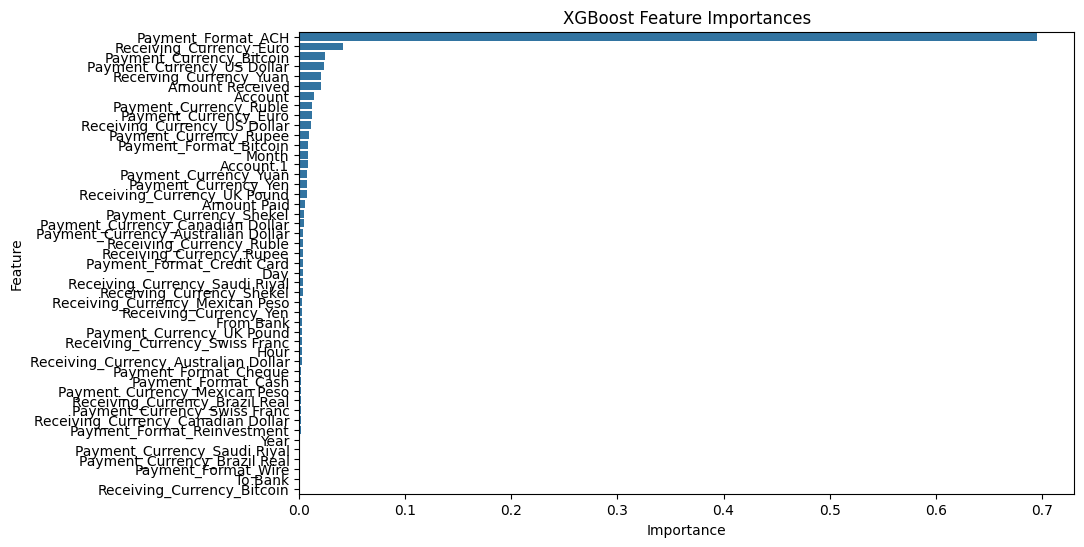

In [ ]:
feature_importances = xgb_model.feature_importances_

feature_imp_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})
feature_imp_df = feature_imp_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_imp_df)
plt.title('XGBoost Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

####Baseline AdaBoost Model

AdaBoost - Accuracy: 0.932489702449107
AdaBoost - Precision: 0.42186059376728746
AdaBoost - Recall: 0.7792506386602328
AdaBoost - F1 Score: 0.5473850018942037
AdaBoost - False Positive Rate: 0.05903869692119386


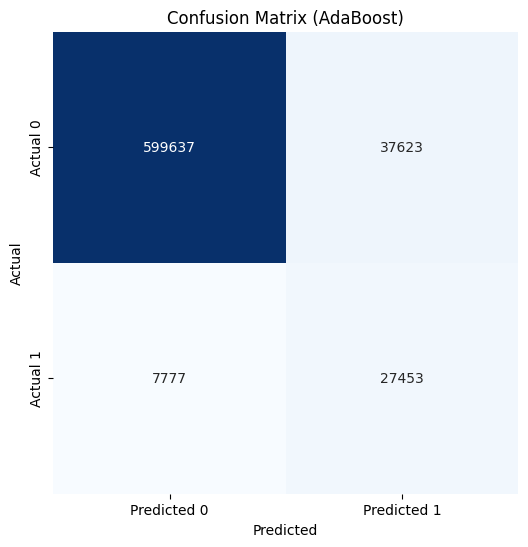

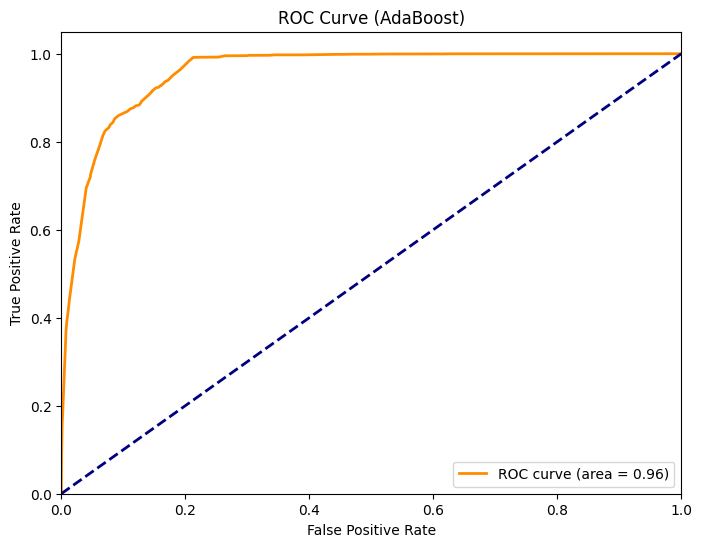

In [ ]:
# Train AdaBoost model
ada_model.fit(X_train, y_train)
y_pred_ada = ada_model.predict(X_test)
y_prob_ada = ada_model.predict_proba(X_test)[:, 1]

# Evaluate the model
accuracy_ada = accuracy_score(y_test, y_pred_ada)
precision_ada = precision_score(y_test, y_pred_ada)
recall_ada = recall_score(y_test, y_pred_ada)
f1_ada = f1_score(y_test, y_pred_ada)

# Calculate the confusion matrix
conf_matrix_ada = confusion_matrix(y_test, y_pred_ada)

# Extract TN, FP, FN, TP from the confusion matrix
TN = conf_matrix_ada[0, 0]
FP = conf_matrix_ada[0, 1]
FN = conf_matrix_ada[1, 0]
TP = conf_matrix_ada[1, 1]

# Calculate False Positive Rate (FPR)
FPR_ada = FP / (FP + TN) if (FP + TN) != 0 else 0  # Handle potential ZeroDivisionError

# ROC Curve
fpr_ada, tpr_ada, thresholds_ada = roc_curve(y_test, y_prob_ada)
roc_auc_ada = auc(fpr_ada, tpr_ada)

print(f"AdaBoost - Accuracy: {accuracy_ada}")
print(f"AdaBoost - Precision: {precision_ada}")
print(f"AdaBoost - Recall: {recall_ada}")
print(f"AdaBoost - F1 Score: {f1_ada}")
print(f"AdaBoost - False Positive Rate: {FPR_ada}")

# Visualize the Confusion Matrix
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix_ada, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix (AdaBoost)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Visualize the ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_ada, tpr_ada, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_ada:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (AdaBoost)')
plt.legend(loc="lower right")
plt.show()

AdaBoost Validation - Accuracy: 0.9247491638795987
AdaBoost Validation - Precision: 0.2191200900273297
AdaBoost Validation - Recall: 0.7898396754877343
AdaBoost Validation - F1 Score: 0.34306569343065696
AdaBoost Validation - False Positive Rate: 0.07180907419909623


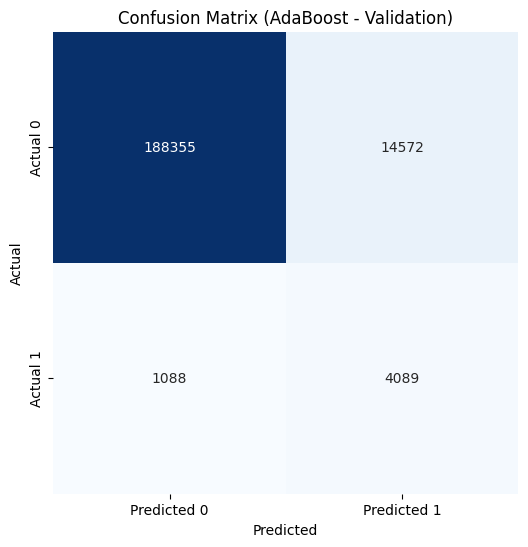

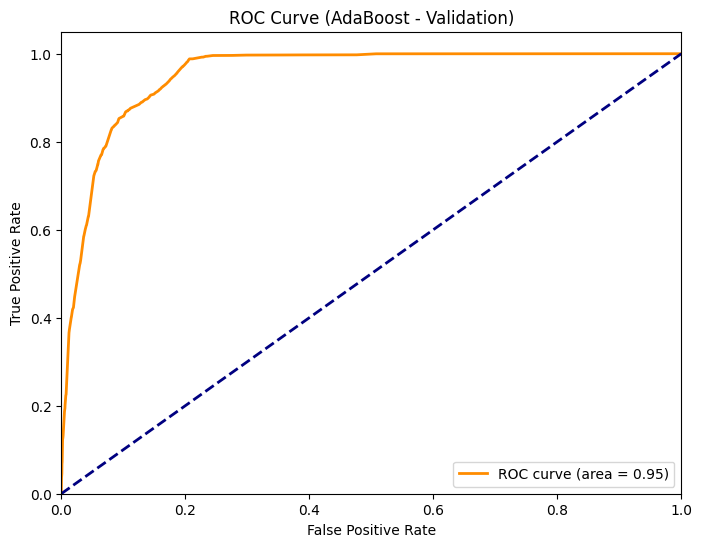

In [ ]:
# Validate the AdaBoost model with X_val and y_val
y_pred_ada_val = ada_model.predict(X_val)
y_prob_ada_val = ada_model.predict_proba(X_val)[:, 1]

# Evaluate the model on the validation set
accuracy_ada_val = accuracy_score(y_val, y_pred_ada_val)
precision_ada_val = precision_score(y_val, y_pred_ada_val)
recall_ada_val = recall_score(y_val, y_pred_ada_val)
f1_ada_val = f1_score(y_val, y_pred_ada_val)

# Calculate the confusion matrix for the validation set
conf_matrix_ada_val = confusion_matrix(y_val, y_pred_ada_val)

# Extract TN, FP, FN, TP from the confusion matrix
TN_val = conf_matrix_ada_val[0, 0]
FP_val = conf_matrix_ada_val[0, 1]
FN_val = conf_matrix_ada_val[1, 0]
TP_val = conf_matrix_ada_val[1, 1]

# Calculate False Positive Rate (FPR) for the validation set
FPR_ada_val = FP_val / (FP_val + TN_val) if (FP_val + TN_val) != 0 else 0 # Handle potential ZeroDivisionError

# ROC Curve for the validation set
fpr_ada_val, tpr_ada_val, thresholds_ada_val = roc_curve(y_val, y_prob_ada_val)
roc_auc_ada_val = auc(fpr_ada_val, tpr_ada_val)

print(f"AdaBoost Validation - Accuracy: {accuracy_ada_val}")
print(f"AdaBoost Validation - Precision: {precision_ada_val}")
print(f"AdaBoost Validation - Recall: {recall_ada_val}")
print(f"AdaBoost Validation - F1 Score: {f1_ada_val}")
print(f"AdaBoost Validation - False Positive Rate: {FPR_ada_val}")

import seaborn as sns # Import seaborn for visualization

# Visualize the Confusion Matrix for the validation set
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix_ada_val, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix (AdaBoost - Validation)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Visualize the ROC Curve for the validation set
plt.figure(figsize=(8, 6))
plt.plot(fpr_ada_val, tpr_ada_val, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_ada_val:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (AdaBoost - Validation)')
plt.legend(loc="lower right")
plt.show()

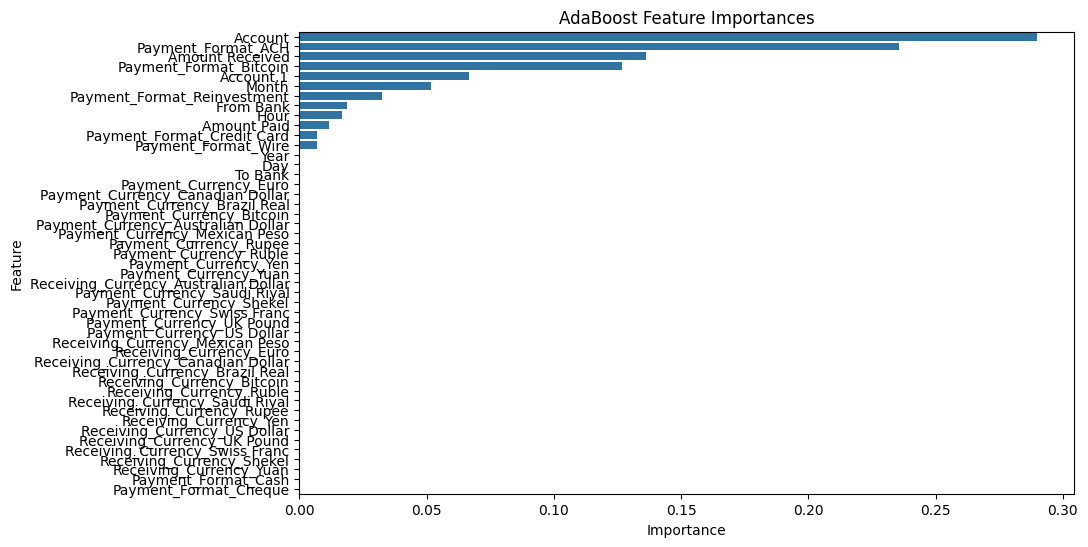

In [ ]:
feature_importances = ada_model.feature_importances_
feature_names = X_train.columns

feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('AdaBoost Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

#Interpret


In this section of the project, the machine learning and deep learning models are evaluated across various metrices as below:
- Accuracy
- Precision
- F1-Score
- Recall
- Confusion Matrix
- ROC Curve
- AUC Curve
- False Positive Rates

##Baseline ML Models

###Youden's J for all Baseline ML Models

Testing

In [ ]:
def calculate_youden_j(y_true, y_prob):
    fpr, tpr, thresholds = roc_curve(y_true, y_prob)
    j_statistic = tpr - fpr
    best_threshold = thresholds[np.argmax(j_statistic)]
    best_j = np.max(j_statistic)
    return best_j, best_threshold

models = {
    'Naive Bayes': (y_test, y_prob_nb),
    'Random Forest': (y_test, y_prob_rf),
    'Logistic Regression': (y_test, y_prob_lr),
    'Decision Tree': (y_test, y_prob_dt),
    'Gradient Boosting': (y_test, y_prob_gb),
    'XGBoost': (y_test, y_prob_xgb),
    'AdaBoost': (y_test, y_prob_ada),
}

for model_name, (y_true, y_prob) in models.items():
    youden_j, threshold = calculate_youden_j(y_true, y_prob)
    print(f"{model_name} - Youden's J: {youden_j:.2f}, Optimal Threshold: {threshold:.2f}")

Naive Bayes - Youden's J: 0.30, Optimal Threshold: 0.01
Random Forest - Youden's J: 0.81, Optimal Threshold: 0.17
Logistic Regression - Youden's J: 0.32, Optimal Threshold: 0.26
Decision Tree - Youden's J: 0.65, Optimal Threshold: 1.00
Gradient Boosting - Youden's J: 0.80, Optimal Threshold: 0.14
XGBoost - Youden's J: 0.81, Optimal Threshold: 0.08
AdaBoost - Youden's J: 0.78, Optimal Threshold: 0.38


Validation

In [ ]:
# prompt: count the Youden's J for the validation models

def calculate_youden_j(y_true, y_prob):
    fpr, tpr, thresholds = roc_curve(y_true, y_prob)
    j_statistic = tpr - fpr
    best_threshold = thresholds[np.argmax(j_statistic)]
    best_j = np.max(j_statistic)
    return best_j, best_threshold

# Assuming you have y_val and y_prob_val for each validation model
validation_models = {
    'Naive Bayes': (y_val, y_prob_nb_val),  # Replace with your actual validation data and probabilities
    'Random Forest': (y_val, y_prob_rf_val),
    'Logistic Regression': (y_val, y_prob_lr_val),
    'Decision Tree': (y_val, y_prob_dt_val),
    'Gradient Boosting': (y_val, y_prob_gb_val),
    'XGBoost': (y_val, y_prob_xgb_val),
    'AdaBoost': (y_val, y_prob_ada_val),
}

for model_name, (y_true, y_prob) in validation_models.items():
    youden_j, threshold = calculate_youden_j(y_true, y_prob)
    print(f"{model_name} - Youden's J: {youden_j:.2f}, Optimal Threshold: {threshold:.2f}")

Naive Bayes - Youden's J: 0.09, Optimal Threshold: 0.01
Random Forest - Youden's J: 0.81, Optimal Threshold: 0.12
Logistic Regression - Youden's J: 0.15, Optimal Threshold: 0.48
Decision Tree - Youden's J: 0.62, Optimal Threshold: 1.00
Gradient Boosting - Youden's J: 0.80, Optimal Threshold: 0.13
XGBoost - Youden's J: 0.82, Optimal Threshold: 0.13
AdaBoost - Youden's J: 0.78, Optimal Threshold: 0.41


###Compilation of ROC Curves

Testing

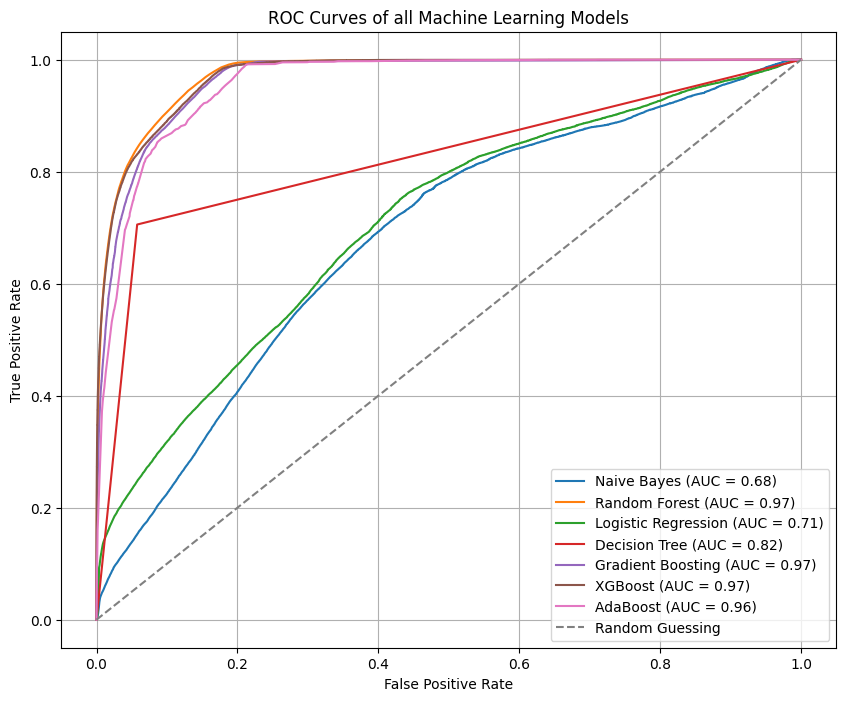

In [ ]:
plt.figure(figsize=(10, 8))
plt.plot(fpr_nb, tpr_nb, label=f'Naive Bayes (AUC = {roc_auc_nb:.2f})')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_rf:.2f})')
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {roc_auc_lr:.2f})')
plt.plot(fpr_dt, tpr_dt, label=f'Decision Tree (AUC = {roc_auc_dt:.2f})')
plt.plot(fpr_gb, tpr_gb, label=f'Gradient Boosting (AUC = {roc_auc_gb:.2f})')
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {roc_auc_xgb:.2f})')
plt.plot(fpr_ada, tpr_ada, label=f'AdaBoost (AUC = {roc_auc_ada:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guessing')  # Add random guessing line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves of all Machine Learning Models')
plt.legend()
plt.grid(True)
plt.show()

Validation

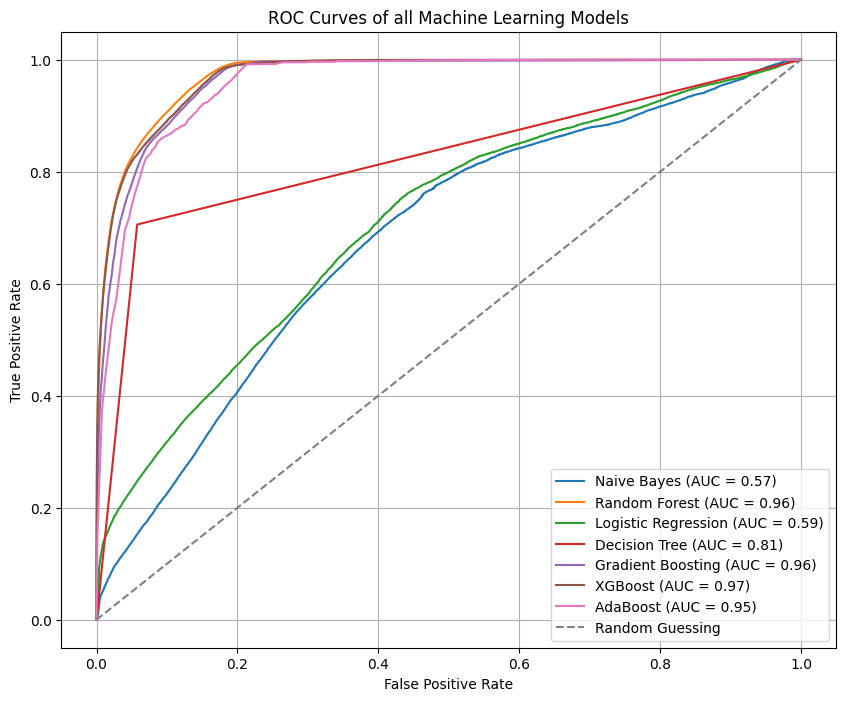

In [ ]:
plt.figure(figsize=(10, 8))
plt.plot(fpr_nb, tpr_nb, label=f'Naive Bayes (AUC = {roc_auc_nb_val:.2f})')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_rf_val:.2f})')
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {roc_auc_lr_val:.2f})')
plt.plot(fpr_dt, tpr_dt, label=f'Decision Tree (AUC = {roc_auc_dt_val:.2f})')
plt.plot(fpr_gb, tpr_gb, label=f'Gradient Boosting (AUC = {roc_auc_gb_val:.2f})')
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {roc_auc_xgb_val:.2f})')
plt.plot(fpr_ada, tpr_ada, label=f'AdaBoost (AUC = {roc_auc_ada_val:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guessing')  # Add random guessing line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves of all Machine Learning Models')
plt.legend()
plt.grid(True)
plt.show()

###Table of Evaluation Metrices

Testing

In [ ]:
data = {
    'Model': ['Naive Bayes', 'Random Forest', 'Logistic Regression', 'Decision Tree', 'Gradient Boosting', 'XGBoost', 'AdaBoost'],
    'Accuracy': [accuracy_nb, accuracy_rf, accuracy_lr, accuracy_dt, accuracy_gb, accuracy_xgb, accuracy_ada],
    'Precision': [precision_nb, precision_rf, precision_lr, precision_dt, precision_gb, precision_xgb, precision_ada],
    'Recall': [recall_nb, recall_rf, recall_lr, recall_dt, recall_gb, recall_xgb, recall_ada],
    'F1 Score': [f1_nb, f1_rf, f1_lr, f1_dt, f1_gb, f1_xgb, f1_ada],
    'False Positive Rate': [FPR_nb, FPR_rf, FPR_lr, FPR_dt, FPR_gb, FPR_xgb, FPR_ada],
    'ROC AUC': [roc_auc_nb, roc_auc_rf, roc_auc_lr, roc_auc_dt, roc_auc_gb, roc_auc_xgb, roc_auc_ada]
}

df = pd.DataFrame(data)
df

Model  Accuracy  Precision    Recall  F1 Score  \
0          Naive Bayes  0.947494   0.243590  0.001079  0.002148   
1        Random Forest  0.960779   0.600999  0.747743  0.666388   
2  Logistic Regression  0.949091   0.589421  0.092989  0.160635   
3        Decision Tree  0.929879   0.403277  0.705705  0.513254   
4    Gradient Boosting  0.941839   0.466784  0.774454  0.582487   
5              XGBoost  0.957660   0.571937  0.762447  0.653592   
6             AdaBoost  0.932490   0.421861  0.779251  0.547385   

   False Positive Rate   ROC AUC  
0             0.000185  0.681447  
1             0.027444  0.973154  
2             0.003581  0.707775  
3             0.057728  0.823988  
4             0.048908  0.965534  
5             0.031548  0.971487  
6             0.059039  0.957790

Validation

In [ ]:
data_val = {
    'Model': ['Naive Bayes', 'Random Forest', 'Logistic Regression', 'Decision Tree', 'Gradient Boosting', 'XGBoost', 'AdaBoost'],
    'Accuracy': [accuracy_nb_val, accuracy_rf_val, accuracy_lr_val, accuracy_dt_val, accuracy_gb_val, accuracy_xgb_val, accuracy_ada_val],
    'Precision': [precision_nb_val, precision_rf_val, precision_lr_val, precision_dt_val, precision_gb_val, precision_xgb_val, precision_ada_val],
    'Recall': [recall_nb_val, recall_rf_val, recall_lr_val, recall_dt_val, recall_gb_val, recall_xgb_val, recall_ada_val],
    'F1 Score': [f1_nb_val, f1_rf_val, f1_lr_val, f1_dt_val, f1_gb_val, f1_xgb_val, f1_ada_val],
    'False Positive Rate': [FPR_nb_val, FPR_rf_val, FPR_lr_val, FPR_dt_val, FPR_gb_val, FPR_xgb_val, FPR_ada_val],
    'ROC AUC': [roc_auc_nb_val, roc_auc_rf_val, roc_auc_lr_val, roc_auc_dt_val, roc_auc_gb_val, roc_auc_xgb_val, roc_auc_ada_val]
}

df = pd.DataFrame(data_val)
df

Model  Accuracy  Precision    Recall  F1 Score  \
0          Naive Bayes  0.974907   0.090909  0.000966  0.001911   
1        Random Forest  0.957569   0.332447  0.700019  0.450802   
2  Logistic Regression  0.973100   0.324437  0.075140  0.122020   
3        Decision Tree  0.927930   0.209386  0.683407  0.320558   
4    Gradient Boosting  0.933024   0.244264  0.808190  0.375146   
5              XGBoost  0.952226   0.315838  0.789260  0.451143   
6             AdaBoost  0.924749   0.219120  0.789840  0.343066   

   False Positive Rate   ROC AUC  
0             0.000246  0.566978  
1             0.035860  0.963913  
2             0.003992  0.593463  
3             0.065832  0.808788  
4             0.063791  0.959398  
5             0.043617  0.969581  
6             0.071809  0.952593